# Análisis de sentimientos y Clusterización con NLP

## Dependencias

In [1]:
# librerías necesarias
import pandas as pd
import re
import spacy
import numpy as np
import matplotlib.pyplot as plt
import nltk
import string
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN


# nltk.download('punkt')
# nltk.download('punk_tab')
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('vader_lexicon')


## Revisión del dataset

In [2]:
# Carga de datos
raw_data = pd.read_csv('Dirty_Evaluation_Data.csv')

In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8649 entries, 0 to 8648
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Id Instructor                 7824 non-null   float64
 1   Grado Académico               7784 non-null   object 
 2   Catálogo                      7784 non-null   object 
 3   Curso                         7831 non-null   float64
 4   Nº Clase                      7838 non-null   float64
 5   Nombre Catalogo               7784 non-null   object 
 6   Modo de Enseñanza             7784 non-null   object 
 7   Fecha Inicio real             7784 non-null   object 
 8   Fecha Fin real                7784 non-null   object 
 9   Centro de Costos              7784 non-null   object 
 10  Nota final por curso          7831 non-null   float64
 11  Competencia Evaluada          7784 non-null   object 
 12  Nota competencia por clase    7825 non-null   float64
 13  Not

In [4]:
raw_data.head()

,Id Instructor,Grado Académico,Catálogo,Curso,Nº Clase,Nombre Catalogo,Modo de Enseñanza,Fecha Inicio real,Fecha Fin real,Centro de Costos,Nota final por curso,Competencia Evaluada,Nota competencia por clase,Nota final por clase,Pregunta,Calificación Pregunta,Comentarios,Total Evaluaciones generadas,Evaluaciones realizadas,% de participación
0,1.000096e+09,PREG,PS0301,NaN,NaN,NaN,Presencial,2024-01-24,2024-05-22,Depto. de Psicología,4.39,NaN,0.0,4.39,Menciona un aspecto a mejorar del desempeño de...,0.0,la practica de los temas,24.0,24.0,100.0
1,1.000096e+09,PREG,PS0301,NaN,1383.0,Análisis Descriptivo de Datos,Pcsaielenr,NaN,NaN,Depto. de Psicología,4.39,Comentarios,0.0,50.00,Menciona un aspecto a mejorar del desempeño de...,0.0,No sé en ocurre ninguna,24.0,24.0,NaN
2,1.000096e+09,PREG,NaN,1317080.0,1383.0,NaN,Presencial,2024-01-24,2024-05-22,Depto. de Psicología,4.39,Comentarios,0.0,4.39,Menciona un aspecto positivo del desempeño de ...,NaN,Su buen sentido del humor a veces facilita la ...,24.0,24.0,100.0
3,NaN,PREG,PS0302,125596.0,1384.0,El Objeto de la Psicología,Presencial,NaN,2024-05-20,Depto. de Psicología,4.57,Comentarios,0.0,4.57,Menciona un aspecto a mejorar del desempeño de...,0.0,retroalimentar al final de la clase,NaN,22.0,NaN
4,1.000005e+09,PREG,PS0302,125596.0,1384.0,El Objeto de la Psicología,Presencial,2024-01-22,2024-05-20,de ocgDtlíPspai.oeo,4.57,Comentarios,0.0,4.57,tjloomd e car rum lerausuca ee nf eeanepdMen ...,0.0,Podría evaluar la forma de dictar la clase par...,22.0,22.0,100.0


In [5]:
raw_data.isnull().sum()

Id Instructor                   825
Grado Académico                 865
Catálogo                        865
Curso                           818
Nº Clase                        811
Nombre Catalogo                 865
Modo de Enseñanza               865
Fecha Inicio real               865
Fecha Fin real                  865
Centro de Costos                865
Nota final por curso            818
Competencia Evaluada            865
Nota competencia por clase      824
Nota final por clase            823
Pregunta                        865
Calificación Pregunta           826
Comentarios                     912
Total Evaluaciones generadas    815
Evaluaciones realizadas         828
% de participación              828
dtype: int64

In [6]:
# Valores nulos por fila
raw_data.isnull().any(axis=1).sum()

7532

In [7]:
# Porcentaje de valores nulos en cada columna
(raw_data.isnull().sum() / len(raw_data)) * 100

Id Instructor                    9.538675
Grado Académico                 10.001156
Catálogo                        10.001156
Curso                            9.457741
Nº Clase                         9.376807
Nombre Catalogo                 10.001156
Modo de Enseñanza               10.001156
Fecha Inicio real               10.001156
Fecha Fin real                  10.001156
Centro de Costos                10.001156
Nota final por curso             9.457741
Competencia Evaluada            10.001156
Nota competencia por clase       9.527113
Nota final por clase             9.515551
Pregunta                        10.001156
Calificación Pregunta            9.550237
Comentarios                     10.544572
Total Evaluaciones generadas     9.423055
Evaluaciones realizadas          9.573361
% de participación               9.573361
dtype: float64

In [8]:
# Eliminación de valores nulos para verificar el volumen de data que se pierde
raw_data1 = raw_data.dropna()

In [9]:
raw_data1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1117 entries, 4 to 8648
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Id Instructor                 1117 non-null   float64
 1   Grado Académico               1117 non-null   object 
 2   Catálogo                      1117 non-null   object 
 3   Curso                         1117 non-null   float64
 4   Nº Clase                      1117 non-null   float64
 5   Nombre Catalogo               1117 non-null   object 
 6   Modo de Enseñanza             1117 non-null   object 
 7   Fecha Inicio real             1117 non-null   object 
 8   Fecha Fin real                1117 non-null   object 
 9   Centro de Costos              1117 non-null   object 
 10  Nota final por curso          1117 non-null   float64
 11  Competencia Evaluada          1117 non-null   object 
 12  Nota competencia por clase    1117 non-null   float64
 13  Nota fin

## Limpieza del dataset

In [10]:
raw_data_clean = raw_data.copy()

### Categorías

Primero se abordan las columnas categóricas, cuyos valores son facilmente identificables:

In [11]:
# Valores únicos de la columna 'Grado Académico'
raw_data['Grado Académico'].unique()

array(['PREG', nan, 'GPER', 'PGRE', 'EPGR', 'ERPG', 'ERGP', 'RPGE',
       'PERG', 'GREP', 'PEGR', 'PGER', 'RGEP', 'EGPR', 'GERP', 'REGP',
       'EGRP', 'GPRE', 'RGPE', 'GRPE', 'DOCT', 'MSTR', 'TMRS', 'GEPR',
       'RPEG', 'REPG', 'EPRG', 'PRGE', 'MTSR', 'TRMS', 'TMSR', 'MRTS',
       'RSTM', 'TSRM', 'CDTO', 'OCDT', 'RSMT', 'MRST', 'STRM', 'SRMT',
       'RMST', 'SRTM', 'MSRT', 'TCDO', 'SMRT', 'TSMR', 'MTRS', 'SMTR',
       'RTSM', 'CODT', 'DTCO', 'TRSM', 'STMR', 'OCTD', 'CTDO', 'ODCT'],
      dtype=object)

In [12]:
# Reemplazar los valores no coherentes por su valor correcto en la columna 'Grado Académico'
def asignar_categoria(grado_academico):
    """
    Asigna una categoría basada en el grado académico proporcionado.
    Args:
        grado_academico (str): El grado académico a evaluar. Puede ser nulo.
    Returns:
        str: La categoría asignada ('PREG', 'DOCT', 'MSTR') o el grado académico original si no coincide con ninguna categoría.
    Notas:
        - Si el grado académico es nulo, se devuelve tal cual.
        - La evaluación se realiza en mayúsculas, por lo que el grado académico se convierte a mayúsculas antes de la evaluación.
        - Las categorías se determinan si todas las letras de 'PREG', 'DOCT' o 'MSTR' están presentes en el grado académico.
    """
    if pd.isnull(grado_academico):
        return grado_academico
    
    grado_academico = grado_academico.upper()
    
    if all(letra in grado_academico for letra in 'PREG'):
        return 'PREG'
    elif all(letra in grado_academico for letra in 'DOCT'):
        return 'DOCT'
    elif all(letra in grado_academico for letra in 'MSTR'):
        return 'MSTR'
    else:
        return grado_academico

# Aplicar la función a la columna 'Grado Académico'
raw_data_clean.loc[:, 'Grado Académico'] = raw_data_clean['Grado Académico'].apply(asignar_categoria)
print(raw_data_clean['Grado Académico'].unique())

['PREG' nan 'DOCT' 'MSTR']


In [13]:
# Valores únicos de la columna 'Competencia Evaluada'
raw_data['Competencia Evaluada'].unique()

array([nan, 'Comentarios', 'rCoosaitenm', 'osrtmneaCio', 'snoiorateCm',
       'irntsoaemoC', 'msornoCieta', 'eioCmsraotn', 'somCtenioar',
       'oetarsComin', 'oamnerstoiC', 'tmonCaoesir', 'oertmasCnoi',
       'niaCrseomto', 'misCntoaoer', 'Conoatmiesr', 'ersimCotaon',
       'mCsenarioto', 'tCeiroosman', 'msanCtrooie', 'rteosiomaCn',
       'nsaemrotoiC', 'aimnserotCo', 'etoirnsCamo', 'neiCtrosmao',
       'Cneiarmosot', 'monistaCroe', 'rnoetosCima', 'ismteanoCor',
       'Cnoetiramos', 'rmtisConoae', 'oemoitrCnas', 'aenirmsCoto',
       'naemCrtoois', 'eniraootmCs', 'nrioamseCto', 'toniamsreCo',
       'amtionesoCr', 'ostionraeCm', 'aitmsCnoeor', 'oamtineCors',
       'eisaCnmtroo', 'ontCosiemra', 'samnietrooC', 'artonmoCise',
       'satrCiooemn', 'ierCaosotnm', 'omoisrteCna', 'simrotaeCno',
       'miCoaseornt', 'Cirmnaootes', 'oansoieCmtr', 'morintsaoCe',
       'tsCenmoiora', 'Cnoestarmoi', 'enCmsioroat', 'imatsoroenC',
       'ornCetsimao', 'tCmosoiaren', 'Cnitaroesom', 'neat

In [14]:
# Reemplazar los valores no coherentes por su valor correcto en la columna 'Competencia Evaluada'
def asignar_categoria(competencia_evaluada):
    """
    Asigna una categoría basada en la competencia evaluada proporcionada.
    Args:
        competencia_evaluada (str): La competencia evaluada que se va a categorizar.
    Returns:
        str: La categoría asignada. Si la competencia evaluada contiene todas las letras
             de la palabra 'comentarios', se devuelve 'Comentarios'. Si la competencia
             evaluada es nula, se devuelve tal cual. En cualquier otro caso, se devuelve
             la competencia evaluada en minúsculas.
    """
    if pd.isnull(competencia_evaluada):
        return competencia_evaluada
    
    competencia_evaluada = competencia_evaluada.lower()
    
    if all(letra in competencia_evaluada for letra in 'comentarios'):
        return 'Comentarios'
    else:
        return competencia_evaluada

# Aplicar la función a la columna 'Competencia Evaluada'
raw_data_clean.loc[:, 'Competencia Evaluada'] = raw_data_clean['Competencia Evaluada'].apply(asignar_categoria)
print(raw_data_clean['Competencia Evaluada'].unique())

[nan 'Comentarios']


In [15]:
# valores únicos de la columna 'Modo de Enseñanza'
raw_data['Modo de Enseñanza'].unique()

array(['Presencial', 'Pcsaielenr', nan, 'snliacerPe', 'laPercsnei',
       'iPesclnaer', 'snreaPceil', 'eaPcseriln', 'elasPiernc',
       'lnraiePsec', 'rPncalesie', 'risencPael', 'clPenirsae',
       'ranleePcis', 'lsPrcineae', 'elPnacirse', 'escaienlrP',
       'clansrPeei', 'erePnlcsai', 'Pscaeelrni', 'nPlsraeeic',
       'canPresiel', 'Pslcnrieea', 'Psaenceril', 'Palieenrcs',
       'lncaiePrse', 'ceelPiarsn', 'lericnesPa', 'elicnrePsa',
       'lsnericaPe', 'inceraelPs', 'ilcPsnaree', 'elsrPcanei',
       'ianleersPc', 'clePsiaren', 'aclPseerin', 'aePslienrc',
       'eescnPlari', 'lcnresieaP', 'eserlcPnai', 'elearcsnPi',
       'snPeelaric', 'ncreslPeai', 'Prseicnela', 'celnaPsier',
       'Pnraeiecls', 'Percienals', 'seacPlneir', 'ePrceinasl',
       'ecersaiPln', 'aesecPnril', 'sacenierPl', 'leniraecPs',
       'larecesnPi', 'Peanclsire', 'slcanePrie', 'eiarescPln',
       'elirsaPnec', 'reiPnaselc', 'ierlcPsean', 'nPslerieac',
       'earlnseiPc', 'lePraiecns', 'iePnclsare', '

In [16]:
# Reemplazar los valores no coherentes por su valor correcto en la columna 'Modo de Enseñanza'
def asignar_categoria(modo_enseñanza):
    """
    Asigna una categoría basada en el modo de enseñanza proporcionado.
    Args:
        modo_enseñanza (str): El modo de enseñanza a categorizar. Puede ser una cadena de texto o NaN.
    Returns:
        str: La categoría asignada. Puede ser 'Presencial', 'Virtual (Formal)' o el valor original si no coincide con ninguna categoría.
    Nota:
        - Si el valor de `modo_enseñanza` es NaN, se devuelve tal cual.
        - La comparación se realiza en minúsculas.
        - La categoría 'Presencial' se asigna si todas las letras de la palabra 'presencial' están presentes en `modo_enseñanza`.
        - La categoría 'Virtual (Formal)' se asigna si todas las letras de la frase 'virtual (formal)' están presentes en `modo_enseñanza`.
    """
    if pd.isnull(modo_enseñanza):
        return modo_enseñanza
    
    modo_enseñanza = modo_enseñanza.lower()
    
    if all(letra in modo_enseñanza for letra in 'presencial'):
        return 'Presencial'
    elif all(letra in modo_enseñanza for letra in 'virtual (formal)'):
        return 'Virtual (Formal)'
    else:
        return modo_enseñanza

# Aplicar la función a la columna 'Modo de Enseñanza'
raw_data_clean.loc[:, 'Modo de Enseñanza'] = raw_data_clean['Modo de Enseñanza'].apply(asignar_categoria)
print(raw_data_clean['Modo de Enseñanza'].unique())

['Presencial' nan 'Virtual (Formal)']


### Pregunta

In [17]:
# Valores únicos de la columna 'Pregunta'
raw_data['Pregunta'].unique()

array(['Menciona un aspecto a mejorar del desempeño de tu profe en el aula',
       'Menciona un aspecto positivo del desempeño de tu profe en el aula',
       'tjloomd e car rum lerausuca ee nf  eeanepdMen saoañtiepn pod eleo ',
       nan,
       'enlu l srdlooe meatoemj see reppecfnnten Maupr aodñ o  ae aacieud ',
       '¿Tienes algún comentario adicional de tu profe o del curso?',
       'u n neltte doñaaundepcueis pnse rMas olfp  a oieetovmeo opeidec l',
       'etnpM rp l ej onu euaa ñc ideesc nfn t usraeoom  paoldleaeeoeraedm',
       'oa astef  pppuuoleecanso oieeeulo dervonmñincln   eedpdas ieM t t',
       'aú?prndocdn ic usnTeioe dg u lfeesa rlico tan eoa torml¿oie',
       ' afclemmoj   pneoeodc nt nñu   dMeeieoesuoe arp pasadtreena aelrlu',
       'dsppuaeaep cflrr  e e saaooalomne o ut iddcreeeeMnm ñ  uae tnoejnl',
       'f s epme   aoauo  oceterdpene nllruencteam laoi Marsd ñdne opeujae',
       ' aestu dntpl e aeei ticsñsnapdlooernfe  aodoulepniemu vopM  coee ',
     

In [18]:
# Lista de palabras clave
palabras_clave = ['profe', 'curso', 'compañero', 'aula']

# Filtrar las preguntas que contengan alguna de las palabras clave
preguntas_filtradas = raw_data_clean['Pregunta'].dropna().unique()  # Primero eliminamos nulos y obtenemos valores únicos
preguntas_frases = [pregunta for pregunta in preguntas_filtradas if any(palabra in pregunta.lower() for palabra in palabras_clave)]

# Mostrar los valores únicos que contienen las palabras clave
preguntas_frases

['Menciona un aspecto a mejorar del desempeño de tu profe en el aula',
 'Menciona un aspecto positivo del desempeño de tu profe en el aula',
 '¿Tienes algún comentario adicional de tu profe o del curso?',
 'Aspectos a mejorar sobre el profesor:',
 'Aspectos positivos sobre el profesor:',
 'Aspectos positivos sobre el curso:',
 'Aspectos a mejorar sobre el curso:']

In [19]:
# Dataframe con las preguntas que representan frases coherentes
preguntas_coherentes = pd.DataFrame(preguntas_frases, columns=['Pregunta'])
preguntas_coherentes

,Pregunta
0,Menciona un aspecto a mejorar del desempeño de...
1,Menciona un aspecto positivo del desempeño de ...
2,¿Tienes algún comentario adicional de tu profe...
3,Aspectos a mejorar sobre el profesor:
4,Aspectos positivos sobre el profesor:
5,Aspectos positivos sobre el curso:
6,Aspectos a mejorar sobre el curso:


In [20]:
# Función para normalizar las cadenas de texto (eliminar puntuación y espacios)
def normalizar_cadena(cadena):
    cadena = re.sub(r'\W+', '', cadena.lower())  
    return ''.join(sorted(cadena))  

# Crear un diccionario de preguntas coherentes normalizadas 
def crear_diccionario_permutaciones(df_frases, columna_frases):
    diccionario_permutaciones = {}
    for frase in df_frases[columna_frases]:
        cadena_normalizada = normalizar_cadena(frase)
        diccionario_permutaciones[cadena_normalizada] = frase
    return diccionario_permutaciones

# Función para corregir cadenas incoherentes
def corregir_cadena(cadena, diccionario_permutaciones):
    cadena_normalizada = normalizar_cadena(cadena)
    return diccionario_permutaciones.get(cadena_normalizada, cadena)

# Crear el diccionario con las permutaciones normalizadas desde las preguntas coherentes
diccionario_permutaciones = crear_diccionario_permutaciones(preguntas_coherentes, 'Pregunta')

preguntas_corregidas = pd.DataFrame(raw_data_clean['Pregunta'].dropna().unique(), columns=['Pregunta'])

# Crear la nueva columna 'Pregunta_Corregida' directamente
preguntas_corregidas['Pregunta_Corregida'] = preguntas_corregidas['Pregunta'].apply(lambda x: corregir_cadena(x, diccionario_permutaciones))
preguntas_corregidas


,Pregunta,Pregunta_Corregida
0,Menciona un aspecto a mejorar del desempeño de...,Menciona un aspecto a mejorar del desempeño de...
1,Menciona un aspecto positivo del desempeño de ...,Menciona un aspecto positivo del desempeño de ...
2,tjloomd e car rum lerausuca ee nf eeanepdMen ...,Menciona un aspecto a mejorar del desempeño de...
3,enlu l srdlooe meatoemj see reppecfnnten Maupr...,Menciona un aspecto a mejorar del desempeño de...
4,¿Tienes algún comentario adicional de tu profe...,¿Tienes algún comentario adicional de tu profe...
...,...,...
776,t oepiraeedea t ices teo slm vonsne eoeunn añ...,Menciona un aspecto positivo del desempeño de ...
777,tfoMsepuoana lueutñse mopoiiap le ieel a c ve...,Menciona un aspecto positivo del desempeño de ...
778,oortod ep tain pelñi dcecsesMtnopaf nimoaeeu...,Menciona un aspecto positivo del desempeño de ...
779,o sduocopedMf eeuaee peiv oñ ol etlud ansoc...,Menciona un aspecto positivo del desempeño de ...


In [21]:
# Crear un diccionario con la pregunta original como clave y la pregunta corregida como valor
diccionario_reemplazo = dict(zip(preguntas_corregidas['Pregunta'], preguntas_corregidas['Pregunta_Corregida']))

# Función para reemplazar las preguntas incoherentes en el dataset original
def reemplazar_pregunta(cadena):
    # Si la cadena está en el diccionario de reemplazo, devolver la corregida
    # Si no, devolver la cadena original
    return diccionario_reemplazo.get(cadena, cadena)

# Aplicar la función de reemplazo sobre la columna 'Pregunta' del dataset original
raw_data_clean['Pregunta'] = raw_data_clean['Pregunta'].apply(lambda x: reemplazar_pregunta(x))
raw_data_clean.head()


,Id Instructor,Grado Académico,Catálogo,Curso,Nº Clase,Nombre Catalogo,Modo de Enseñanza,Fecha Inicio real,Fecha Fin real,Centro de Costos,Nota final por curso,Competencia Evaluada,Nota competencia por clase,Nota final por clase,Pregunta,Calificación Pregunta,Comentarios,Total Evaluaciones generadas,Evaluaciones realizadas,% de participación
0,1.000096e+09,PREG,PS0301,NaN,NaN,NaN,Presencial,2024-01-24,2024-05-22,Depto. de Psicología,4.39,NaN,0.0,4.39,Menciona un aspecto a mejorar del desempeño de...,0.0,la practica de los temas,24.0,24.0,100.0
1,1.000096e+09,PREG,PS0301,NaN,1383.0,Análisis Descriptivo de Datos,Presencial,NaN,NaN,Depto. de Psicología,4.39,Comentarios,0.0,50.00,Menciona un aspecto a mejorar del desempeño de...,0.0,No sé en ocurre ninguna,24.0,24.0,NaN
2,1.000096e+09,PREG,NaN,1317080.0,1383.0,NaN,Presencial,2024-01-24,2024-05-22,Depto. de Psicología,4.39,Comentarios,0.0,4.39,Menciona un aspecto positivo del desempeño de ...,NaN,Su buen sentido del humor a veces facilita la ...,24.0,24.0,100.0
3,NaN,PREG,PS0302,125596.0,1384.0,El Objeto de la Psicología,Presencial,NaN,2024-05-20,Depto. de Psicología,4.57,Comentarios,0.0,4.57,Menciona un aspecto a mejorar del desempeño de...,0.0,retroalimentar al final de la clase,NaN,22.0,NaN
4,1.000005e+09,PREG,PS0302,125596.0,1384.0,El Objeto de la Psicología,Presencial,2024-01-22,2024-05-20,de ocgDtlíPspai.oeo,4.57,Comentarios,0.0,4.57,Menciona un aspecto a mejorar del desempeño de...,0.0,Podría evaluar la forma de dictar la clase par...,22.0,22.0,100.0


### Centro de costos

In [22]:
# Valores únicos de la columna 'Centro de Costos'
raw_data['Centro de Costos'].unique()

array(['Depto. de Psicología', ' de ocgDtlíPspai.oeo', nan,
       'pemoóiCc SD ielun.c danoiotac', 'Depto. de Comunicación Social',
       'detPoloeoíias cDpg .', 'o.eaieDgPo d oltpscí',
       'Popdetg.oei lDa ísoc', 'odipc Dt Paees.ogloí',
       'coeo DipglesaoPdt. í', 'ionoacci mupDeC leS óocdia.nt',
       'Depto de Música', 'Depto. de Humanidades',
       'atd. eem iudpdeaoHnDs', 'lopc odgeitaeíoD .sP',
       'gaetdD.íoocpose  iPl', 'plD  e.soPíadgoiteoc',
       'daioc olpígePt.e soD', 'iDa uiotdcoeó.ecn iomcSnlap C',
       'e oeclots .iapPDídog', 'dDcpi.leo Peíot saog',
       'adoePDogst p.c eíiol', 'eed toíogipcsDoP.a l',
       'íe licdDoosegPap t.o', ' d.leieosogp taoíPcD',
       'Peíceo.o tDgp idsloa', 'g c otalis.ípeoDPdeo',
       'PdoetelciDogía  o.sp', 'geo ptcd. iesoDoPlaí',
       'gs iDoaoe.pPoe ídtlc', ' ptíelde oPsi.ogDoca',
       'at.es ídPoel pgoDioc', 'oD íi.osetoadgecpl P',
       'ip coió dmeaD oceoactSlinn.uC', 'SóloaCDic.octinepnaiom d ue c',
       'c

In [23]:
raw_data['Centro de Costos'].nunique()

777

In [24]:
# Lista de palabras clave
palabras_clave = ['depto', 'formacion', 'humanistica']

# Filtrar las costos que contengan alguna de las palabras clave
costos_filtrados = raw_data_clean['Centro de Costos'].dropna().unique()  # Primero eliminamos nulos y obtenemos valores únicos
costos_frases = [costo for costo in costos_filtrados if any(palabra in costo.lower() for palabra in palabras_clave)]

# Mostrar los valores únicos que contienen las palabras clave
costos_frases

['Depto. de Psicología',
 'Depto. de Comunicación Social',
 'Depto de Música',
 'Depto. de Humanidades',
 'Formación Humanistica y cienti']

In [25]:
# Dataframe con las costos que representan frases coherentes
costos_coherentes = pd.DataFrame(costos_frases, columns=['Centro de Costos'])
costos_coherentes

,Centro de Costos
0,Depto. de Psicología
1,Depto. de Comunicación Social
2,Depto de Música
3,Depto. de Humanidades
4,Formación Humanistica y cienti


In [26]:
# Función para normalizar las cadenas (eliminar puntuación y espacios)
def normalizar_cadena(cadena):
    cadena = re.sub(r'\W+', '', cadena.lower())  # Eliminar signos de puntuación y convertir a minúsculas
    return ''.join(sorted(cadena))  # Ordenar las letras alfabéticamente

# Crear un diccionario de costos coherentes normalizados
def crear_diccionario_permutaciones(df_frases, columna_frases):
    diccionario_permutaciones = {}
    for frase in df_frases[columna_frases]:
        cadena_normalizada = normalizar_cadena(frase)
        diccionario_permutaciones[cadena_normalizada] = frase
    return diccionario_permutaciones

# Función para corregir cadenas incoherentes
def corregir_cadena(cadena, diccionario_permutaciones):
    cadena_normalizada = normalizar_cadena(cadena)
    return diccionario_permutaciones.get(cadena_normalizada, cadena)

# Crear el diccionario con las permutaciones normalizadas desde los costos coherentes
diccionario_permutaciones = crear_diccionario_permutaciones(costos_coherentes, 'Centro de Costos')

costos_corregidos = pd.DataFrame(raw_data_clean['Centro de Costos'].dropna().unique(), columns=['Centro de Costos'])

# Crear la nueva columna 'Pregunta_Corregida' directamente
costos_corregidos['costos_corregido'] = costos_corregidos['Centro de Costos'].apply(lambda x: corregir_cadena(x, diccionario_permutaciones))
costos_corregidos


,Centro de Costos,costos_corregido
0,Depto. de Psicología,Depto. de Psicología
1,de ocgDtlíPspai.oeo,Depto. de Psicología
2,pemoóiCc SD ielun.c danoiotac,Depto. de Comunicación Social
3,Depto. de Comunicación Social,Depto. de Comunicación Social
4,detPoloeoíias cDpg .,Depto. de Psicología
...,...,...
772,elunota eóDCca oip.oiicn cdSm,Depto. de Comunicación Social
773,uHmdnaesa.tie eDdo dp,Depto. de Humanidades
774,ae ediodadpsutemDnH.,Depto. de Humanidades
775,dm peHisdeou tnDada.e,Depto. de Humanidades


In [27]:
# Crear un diccionario con el centro de costos originar como clave y el centro de costos corregidos como valor
diccionario_reemplazo = dict(zip(costos_corregidos['Centro de Costos'], costos_corregidos['costos_corregido']))

# Función para reemplazar los costos incoherentes en el dataset original
def reemplazar_pregunta(cadena):
    # Si la cadena está en el diccionario de reemplazo, devolver la corregida
    # Si no, devolver la cadena original
    return diccionario_reemplazo.get(cadena, cadena)

# Aplicar la función de reemplazo sobre la columna 'Centro de Csotos' del dataset original
raw_data_clean['Centro de Costos'] = raw_data_clean['Centro de Costos'].apply(lambda x: reemplazar_pregunta(x))
raw_data_clean.head()


,Id Instructor,Grado Académico,Catálogo,Curso,Nº Clase,Nombre Catalogo,Modo de Enseñanza,Fecha Inicio real,Fecha Fin real,Centro de Costos,Nota final por curso,Competencia Evaluada,Nota competencia por clase,Nota final por clase,Pregunta,Calificación Pregunta,Comentarios,Total Evaluaciones generadas,Evaluaciones realizadas,% de participación
0,1.000096e+09,PREG,PS0301,NaN,NaN,NaN,Presencial,2024-01-24,2024-05-22,Depto. de Psicología,4.39,NaN,0.0,4.39,Menciona un aspecto a mejorar del desempeño de...,0.0,la practica de los temas,24.0,24.0,100.0
1,1.000096e+09,PREG,PS0301,NaN,1383.0,Análisis Descriptivo de Datos,Presencial,NaN,NaN,Depto. de Psicología,4.39,Comentarios,0.0,50.00,Menciona un aspecto a mejorar del desempeño de...,0.0,No sé en ocurre ninguna,24.0,24.0,NaN
2,1.000096e+09,PREG,NaN,1317080.0,1383.0,NaN,Presencial,2024-01-24,2024-05-22,Depto. de Psicología,4.39,Comentarios,0.0,4.39,Menciona un aspecto positivo del desempeño de ...,NaN,Su buen sentido del humor a veces facilita la ...,24.0,24.0,100.0
3,NaN,PREG,PS0302,125596.0,1384.0,El Objeto de la Psicología,Presencial,NaN,2024-05-20,Depto. de Psicología,4.57,Comentarios,0.0,4.57,Menciona un aspecto a mejorar del desempeño de...,0.0,retroalimentar al final de la clase,NaN,22.0,NaN
4,1.000005e+09,PREG,PS0302,125596.0,1384.0,El Objeto de la Psicología,Presencial,2024-01-22,2024-05-20,Depto. de Psicología,4.57,Comentarios,0.0,4.57,Menciona un aspecto a mejorar del desempeño de...,0.0,Podría evaluar la forma de dictar la clase par...,22.0,22.0,100.0


In [28]:
raw_data_clean['Centro de Costos'].value_counts()

Centro de Costos
Depto. de Comunicación Social     3026
Depto. de Humanidades             1921
Depto. de Psicología              1890
Depto de Música                    759
Formación Humanistica y cienti     188
Name: count, dtype: int64

### Nombre Catálogo

In [29]:
(raw_data_clean.isnull().sum() / len(raw_data_clean)) * 100

Id Instructor                    9.538675
Grado Académico                 10.001156
Catálogo                        10.001156
Curso                            9.457741
Nº Clase                         9.376807
Nombre Catalogo                 10.001156
Modo de Enseñanza               10.001156
Fecha Inicio real               10.001156
Fecha Fin real                  10.001156
Centro de Costos                10.001156
Nota final por curso             9.457741
Competencia Evaluada            10.001156
Nota competencia por clase       9.527113
Nota final por clase             9.515551
Pregunta                        10.001156
Calificación Pregunta            9.550237
Comentarios                     10.544572
Total Evaluaciones generadas     9.423055
Evaluaciones realizadas          9.573361
% de participación               9.573361
dtype: float64

In [30]:
# Valores únicos de la columna 'Nombre Catalogo'
raw_data['Nombre Catalogo'].nunique()


1110

In [31]:
# Función para normalizar las cadenas (eliminar puntuación y espacios y ordenar alfabéticamente)
def normalizar_cadena(cadena):
    cadena = re.sub(r'\W+', '', cadena.lower())  # Eliminar signos de puntuación y convertir a minúsculas  
    return ''.join(sorted(cadena))  # Ordenar las letras alfabéticamente

# Valores únicos normalizados de la columna 'Nombre Catalogo'
nombre_catalogo = pd.DataFrame(raw_data_clean['Nombre Catalogo'].dropna().unique(), columns=['Nombre Catalogo'])
nombre_catalogo['Nombre_Catalogo_Normalizado'] = nombre_catalogo['Nombre Catalogo'].apply(lambda x: normalizar_cadena(x) if pd.notnull(x) else x)

# Obtener las cadenas únicas normalizadas
cadenas_unicas = nombre_catalogo[['Nombre Catalogo', 'Nombre_Catalogo_Normalizado']].drop_duplicates()

# Diccionario para guardar la frase coherente más representativa de cada cadena normalizada
diccionario_reemplazo = {}

# Llenar el diccionario con la primera aparición de la frase coherente para cada cadena normalizada
for index, row in cadenas_unicas.iterrows():
    cadena_normalizada = row['Nombre_Catalogo_Normalizado']
    frase_original = row['Nombre Catalogo']
    
    # Si la cadena normalizada aún no está en el diccionario, agregarla
    if cadena_normalizada not in diccionario_reemplazo:
        diccionario_reemplazo[cadena_normalizada] = frase_original

# Diccionario con cadenas restantes manualmente identificadas
diccionario_manual = {'1aacelllortv': 'Taller Vocal 1',
'2aaacdehiiilmorsstú': 'Historia de la Música 2',
'2aadehiijlorstzz': 'Historia del Jazz 2',
'2abeelmns': 'Ensamble 2',
'2acceilllmnnopprssttáí': 'Semin. Pos-Práct Tall. Clín. 2',
'3aaceeiilmmnnooopprt': 'Piano Complementario 3',
'3aacfinnossté': 'Énfasis Canto 3',
'5abeelmns': 'Ensamble 5',
'8aaccciillmnooprrsttuvá': 'Práctica Instruml. o Vocal 8',
'8accceeeffhiilnoopssséí': 'Específico Énfasis Chelo 8',
'9aacceeffiiilnoopsssvéí': 'Específico Énfasis Viola 9',
'aaaaaccciiillmmnorstyéú': 'Música América Latina y Col.',
'aaaacccceefgiiiimnnoprrtáó': 'Apreciación Cinematográfica',
'aaaadeeegimnooprssssttu': 'Empresas Autogestionadas',
'aaabcddddeeehiiiilmnsó': 'Habilidades de Mediación',
'aaaccccdeeeeiiinnoprrssttó': 'Creación de Espacios Interact.',
'aaaceeeggijlmnnnrtuuyó': 'Lenguaje y Argumentación',
'aaadeilnorrstvy': 'Narrativas del Yo',
'aaccddeeefiilnrttuy': 'Arte y Ciudad - Elect. Nfi',
'aaccdeeehiilllrssttty': 'Hist. de la Lect. y la Escrit.',
'aaccdeeiimnnoooppstty': 'Teo. y Aa. Contemp. Psico. Din',
'aaddeeeiilnooorrssttttuvx': 'Estudios del Texto Narrativo',
'adeeeefhiimmnnnrsssé': 'Edición Periodística',
'addeeeeeiiimmnnnorssssttvñ': 'Semin de Invest Diseño Transme',
'adeeeefhiimmnnnrsssé': 'Semin. de Énfasis - Hermen.',
'bccceinooopssstá': 'Conceptos Básicos',
'aaccdeeiimnnoooppstty': 'Teo. y Aa. Contemp. Psico. Din',
'aaccddegiilooopssyí': 'Psicología y Sociedad',
'aaccdeeehiilllrssttty': 'Hist. de la Lect. y la Escrit.'}

# Unir los diccionarios en uno solo
diccionario_final = {**diccionario_reemplazo, **diccionario_manual}

# Normalizar la columna en raw_data_clean
raw_data_clean['Nombre_Catalogo_Normalizado'] = raw_data_clean['Nombre Catalogo'].apply(lambda x: normalizar_cadena(x) if pd.notnull(x) else x)

# Reemplazar en el DataFrame original usando el diccionario final
raw_data_clean['Nombre Catalogo'] = raw_data_clean['Nombre_Catalogo_Normalizado'].map(diccionario_final).fillna(raw_data_clean['Nombre Catalogo'])

# Eliminar la columna de normalización si no es necesaria
raw_data_clean.drop(columns=['Nombre_Catalogo_Normalizado'], inplace=True)
raw_data_clean.head()


,Id Instructor,Grado Académico,Catálogo,Curso,Nº Clase,Nombre Catalogo,Modo de Enseñanza,Fecha Inicio real,Fecha Fin real,Centro de Costos,Nota final por curso,Competencia Evaluada,Nota competencia por clase,Nota final por clase,Pregunta,Calificación Pregunta,Comentarios,Total Evaluaciones generadas,Evaluaciones realizadas,% de participación
0,1.000096e+09,PREG,PS0301,NaN,NaN,NaN,Presencial,2024-01-24,2024-05-22,Depto. de Psicología,4.39,NaN,0.0,4.39,Menciona un aspecto a mejorar del desempeño de...,0.0,la practica de los temas,24.0,24.0,100.0
1,1.000096e+09,PREG,PS0301,NaN,1383.0,Análisis Descriptivo de Datos,Presencial,NaN,NaN,Depto. de Psicología,4.39,Comentarios,0.0,50.00,Menciona un aspecto a mejorar del desempeño de...,0.0,No sé en ocurre ninguna,24.0,24.0,NaN
2,1.000096e+09,PREG,NaN,1317080.0,1383.0,NaN,Presencial,2024-01-24,2024-05-22,Depto. de Psicología,4.39,Comentarios,0.0,4.39,Menciona un aspecto positivo del desempeño de ...,NaN,Su buen sentido del humor a veces facilita la ...,24.0,24.0,100.0
3,NaN,PREG,PS0302,125596.0,1384.0,El Objeto de la Psicología,Presencial,NaN,2024-05-20,Depto. de Psicología,4.57,Comentarios,0.0,4.57,Menciona un aspecto a mejorar del desempeño de...,0.0,retroalimentar al final de la clase,NaN,22.0,NaN
4,1.000005e+09,PREG,PS0302,125596.0,1384.0,El Objeto de la Psicología,Presencial,2024-01-22,2024-05-20,Depto. de Psicología,4.57,Comentarios,0.0,4.57,Menciona un aspecto a mejorar del desempeño de...,0.0,Podría evaluar la forma de dictar la clase par...,22.0,22.0,100.0


### Catálogo

In [32]:
# Dataframe con las columnas 'Catálogo' y 'Nombre Catalogo'
catalogo = raw_data_clean[['Catálogo', 'Nombre Catalogo']]
catalogo

,Catálogo,Nombre Catalogo
0,PS0301,NaN
1,PS0301,Análisis Descriptivo de Datos
2,NaN,NaN
3,PS0302,El Objeto de la Psicología
4,PS0302,El Objeto de la Psicología
...,...,...
8644,HL0795,Etiología del Comportamiento
8645,HL1001,Curso Básico en Estudios Hist.
8646,HL1001,Curso Básico en Estudios Hist.
8647,NaN,Curso Básico en Estudios Hist.


In [33]:
# Porcentaje de valores nulos en cada columna
(catalogo.isnull().sum() / len(catalogo)) * 100

Catálogo           10.001156
Nombre Catalogo    10.001156
dtype: float64

In [34]:
# Reemplazo de los values nulos en la columna 'Catálogo' usando los valores de la columna 'Nombre Catalogo'
# Crear un DataFrame de referencia para reemplazar valores NaN
catalogo_ref = catalogo.groupby('Nombre Catalogo')['Catálogo'].first().reset_index()
catalogo_ref = catalogo_ref.rename(columns={'Catálogo': 'Catálogo_Referencia'})

# Unir el DataFrame original con el de referencia para obtener el valor del catálogo correspondiente
catalogo = catalogo.merge(catalogo_ref, on='Nombre Catalogo', how='left')

# Reemplazar los valores NaN en la columna 'Catálogo' con los valores del DataFrame de referencia
catalogo['Catálogo_corregido'] = catalogo['Catálogo'].fillna(catalogo['Catálogo_Referencia'])
catalogo = catalogo.drop(columns='Catálogo_Referencia')
catalogo


,Catálogo,Nombre Catalogo,Catálogo_corregido
0,PS0301,NaN,PS0301
1,PS0301,Análisis Descriptivo de Datos,PS0301
2,NaN,NaN,NaN
3,PS0302,El Objeto de la Psicología,PS0302
4,PS0302,El Objeto de la Psicología,PS0302
...,...,...,...
8644,HL0795,Etiología del Comportamiento,HL0795
8645,HL1001,Curso Básico en Estudios Hist.,HL1001
8646,HL1001,Curso Básico en Estudios Hist.,HL1001
8647,NaN,Curso Básico en Estudios Hist.,HL1001


In [35]:
# Reemplazo de los valores nulos en la columna 'Nombre Catalogo' usando los valores de la columna 'Catálogo'
# Crear un DataFrame de referencia para reemplazar valores NaN
nombre_ref = catalogo.groupby('Catálogo')['Nombre Catalogo'].first().reset_index()
nombre_ref = nombre_ref.rename(columns={'Nombre Catalogo': 'Nombre_Catalogo_Referencia'})

# Unir el DataFrame original con el de referencia para obtener el valor del 'Nombre Catalogo' correspondiente
catalogo = catalogo.merge(nombre_ref, on='Catálogo', how='left')

# Reemplazar los valores NaN en la columna 'Nombre Catalogo' con los valores del DataFrame de referencia
catalogo['Nombre Catalogo_corregido'] = catalogo['Nombre Catalogo'].fillna(catalogo['Nombre_Catalogo_Referencia'])
catalogo = catalogo.drop(columns='Nombre_Catalogo_Referencia')
catalogo.head()

,Catálogo,Nombre Catalogo,Catálogo_corregido,Nombre Catalogo_corregido
0,PS0301,NaN,PS0301,Análisis Descriptivo de Datos
1,PS0301,Análisis Descriptivo de Datos,PS0301,Análisis Descriptivo de Datos
2,NaN,NaN,NaN,NaN
3,PS0302,El Objeto de la Psicología,PS0302,El Objeto de la Psicología
4,PS0302,El Objeto de la Psicología,PS0302,El Objeto de la Psicología


In [36]:
# Valores nulos en las columnas 'Catálogo' y 'Nombre Catalogo' después del reemplazo
(catalogo.isnull().sum() / len(raw_data)) * 100

Catálogo                     10.001156
Nombre Catalogo              10.001156
Catálogo_corregido            0.844028
Nombre Catalogo_corregido     1.919297
dtype: float64

In [37]:
# Agrupar por Nombre Catalogo corregido y encontrar el código más frecuente en Catalogo corregido
most_frequent_code = catalogo.groupby('Nombre Catalogo_corregido')['Catálogo_corregido'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)

# Mostrar el mapeo de nombres corregidos a códigos más frecuentes
print("Códigos más frecuentes por Nombre Catalogo corregido:")
print(most_frequent_code)

# Reemplazar los valores en Catálogo con el código más frecuente basado en Nombre Catalogo corregido
catalogo['Catálogo_corregido_calculado'] = catalogo['Nombre Catalogo_corregido'].map(most_frequent_code)

# Mostrar el DataFrame después de aplicar el mapeo
print("DataFrame con Catálogo corregido calculado:")
catalogo.head()

Códigos más frecuentes por Nombre Catalogo corregido:
Nombre Catalogo_corregido
 Estudios de Liter. Colomb.           HL0342
 Probl. Contempor. de Hermen.         HL0332
Acción por el clima                   FH1025
Anatomía del Libro                    HL0319
Animación 2d                          CS0267
                                     ...    
Énfasis Violín 3                      MU2123
Énfasis Violín 5                      MU2125
Ética Profesional                     PS0331
Ética Públ. y Cult. Ciudadana         CS0762
Ética y Respons. Social Emprl.        PS0341
Name: Catálogo_corregido, Length: 321, dtype: object
DataFrame con Catálogo corregido calculado:


,Catálogo,Nombre Catalogo,Catálogo_corregido,Nombre Catalogo_corregido,Catálogo_corregido_calculado
0,PS0301,NaN,PS0301,Análisis Descriptivo de Datos,PS0301
1,PS0301,Análisis Descriptivo de Datos,PS0301,Análisis Descriptivo de Datos,PS0301
2,NaN,NaN,NaN,NaN,NaN
3,PS0302,El Objeto de la Psicología,PS0302,El Objeto de la Psicología,PS0302
4,PS0302,El Objeto de la Psicología,PS0302,El Objeto de la Psicología,PS0302


In [38]:
# Reemplazar las columnas 'Catálogo' y 'Nombre Catalogo' en el DataFrame original
raw_data_clean['Catálogo'] = catalogo['Catálogo_corregido_calculado']
raw_data_clean['Nombre Catalogo'] = catalogo['Nombre Catalogo_corregido']


In [39]:
# Porcejate de valores nulos en cada columna después del reemplazo
(raw_data_clean.isnull().sum() / len(raw_data_clean)) * 100

Id Instructor                    9.538675
Grado Académico                 10.001156
Catálogo                         1.942421
Curso                            9.457741
Nº Clase                         9.376807
Nombre Catalogo                  1.919297
Modo de Enseñanza               10.001156
Fecha Inicio real               10.001156
Fecha Fin real                  10.001156
Centro de Costos                10.001156
Nota final por curso             9.457741
Competencia Evaluada            10.001156
Nota competencia por clase       9.527113
Nota final por clase             9.515551
Pregunta                        10.001156
Calificación Pregunta            9.550237
Comentarios                     10.544572
Total Evaluaciones generadas     9.423055
Evaluaciones realizadas          9.573361
% de participación               9.573361
dtype: float64

### % de participación y otras columnas numéricas

In [40]:
# Descripcion de los datos numéricos
raw_data_clean.describe()

,Id Instructor,Curso,Nº Clase,Nota final por curso,Nota competencia por clase,Nota final por clase,Calificación Pregunta,Total Evaluaciones generadas,Evaluaciones realizadas,% de participación
count,7.824000e+03,7.831000e+03,7838.000000,7831.000000,7825.0,7826.000000,7823.0,7834.000000,7821.000000,7821.000000
mean,1.497232e+09,1.840185e+05,6169.923833,7.187372,0.0,7.187292,0.0,41.709216,38.041555,145.414543
std,2.056527e+09,2.739040e+05,14220.254748,10.350445,0.0,10.354488,0.0,86.975980,75.894808,206.898864
min,1.000000e+09,1.098000e+05,1258.000000,2.960000,0.0,0.000000,0.0,1.000000,1.000000,3.230000
25%,1.000060e+09,1.099600e+05,1421.000000,4.600000,0.0,4.600000,0.0,16.000000,15.000000,94.740000
50%,1.000089e+09,1.157130e+05,1517.000000,4.790000,0.0,4.790000,0.0,21.000000,20.000000,100.000000
75%,1.000125e+09,1.256200e+05,5272.750000,4.920000,0.0,4.920000,0.0,29.000000,28.000000,100.000000
max,1.000363e+10,1.317080e+06,64620.000000,50.000000,0.0,50.000000,0.0,400.000000,350.000000,1000.000000


In [41]:
# En la columna '% de participación' se encuentran valores mayores a 100, lo cual no es posible, se reemplazarán por la media de los valores válidos 
# Filtrar valores válidos (<= 100) para calcular la media
valid_values = raw_data_clean.loc[raw_data_clean['% de participación'] <= 100, '% de participación']

# Calcular la media de los valores válidos
mean_value = valid_values.mean()

# Reemplazar valores mayores a 100 con la media calculada
raw_data_clean['% de participación'] = raw_data_clean['% de participación'].apply(
    lambda x: mean_value if x > 100 else x
)

raw_data_clean['% de participación'] = raw_data_clean['% de participación'].fillna(mean_value)


In [42]:
raw_data_clean['Nota final por curso'].value_counts()

Nota final por curso
50.00    432
4.91     359
4.83     223
4.95     220
4.80     217
        ... 
4.17       2
4.13       2
4.43       1
3.00       1
3.79       1
Name: count, Length: 93, dtype: int64

In [43]:
raw_data_clean['Nota final por curso'] = raw_data_clean['Nota final por curso'].replace(50.00, 5.0)

In [44]:
raw_data_clean['Nota final por clase'].value_counts()

Nota final por clase
50.00    432
4.95     286
4.73     261
4.98     260
4.91     257
        ... 
3.69       4
4.38       4
3.79       3
3.57       2
0.00       1
Name: count, Length: 99, dtype: int64

In [45]:
raw_data_clean['Nota final por clase'] = raw_data_clean['Nota final por clase'].replace(50.00, 5.0)

In [46]:
raw_data_clean.describe()

,Id Instructor,Curso,Nº Clase,Nota final por curso,Nota competencia por clase,Nota final por clase,Calificación Pregunta,Total Evaluaciones generadas,Evaluaciones realizadas,% de participación
count,7.824000e+03,7.831000e+03,7838.000000,7831.000000,7825.0,7826.000000,7823.0,7834.000000,7821.000000,8649.000000
mean,1.497232e+09,1.840185e+05,6169.923833,4.704930,0.0,4.703265,0.0,41.709216,38.041555,95.450960
std,2.056527e+09,2.739040e+05,14220.254748,0.325107,0.0,0.341608,0.0,86.975980,75.894808,9.675527
min,1.000000e+09,1.098000e+05,1258.000000,2.960000,0.0,0.000000,0.0,1.000000,1.000000,3.230000
25%,1.000060e+09,1.099600e+05,1421.000000,4.600000,0.0,4.600000,0.0,16.000000,15.000000,95.000000
50%,1.000089e+09,1.157130e+05,1517.000000,4.790000,0.0,4.790000,0.0,21.000000,20.000000,96.880000
75%,1.000125e+09,1.256200e+05,5272.750000,4.920000,0.0,4.920000,0.0,29.000000,28.000000,100.000000
max,1.000363e+10,1.317080e+06,64620.000000,5.000000,0.0,5.000000,0.0,400.000000,350.000000,100.000000


In [47]:
raw_data_clean['Total Evaluaciones generadas'].value_counts()

Total Evaluaciones generadas
20.0     591
24.0     462
400.0    432
19.0     396
16.0     347
29.0     326
31.0     306
33.0     297
22.0     293
35.0     288
32.0     274
17.0     270
14.0     257
25.0     248
23.0     238
18.0     237
28.0     232
15.0     221
9.0      189
10.0     183
30.0     174
21.0     173
8.0      156
13.0     146
7.0      145
1.0      136
27.0     118
12.0     101
11.0      91
26.0      77
36.0      74
5.0       69
6.0       67
2.0       57
4.0       57
3.0       49
34.0      45
40.0      12
Name: count, dtype: int64

In [48]:
raw_data_clean['Total Evaluaciones generadas'] = raw_data_clean['Total Evaluaciones generadas'].replace(400.00, 40.0)

In [49]:
raw_data_clean['Evaluaciones realizadas'].value_counts()

Evaluaciones realizadas
23.0     456
20.0     447
350.0    432
27.0     405
19.0     391
22.0     362
16.0     322
15.0     317
18.0     313
17.0     293
28.0     279
24.0     255
14.0     250
9.0      248
32.0     246
13.0     204
30.0     202
33.0     191
34.0     189
10.0     189
8.0      171
31.0     170
7.0      168
25.0     165
35.0     156
29.0     152
1.0      150
6.0      119
12.0     102
26.0      83
5.0       81
4.0       68
21.0      68
11.0      68
2.0       55
3.0       54
Name: count, dtype: int64

In [50]:
raw_data_clean['Evaluaciones realizadas'] = raw_data_clean['Evaluaciones realizadas'].replace(350.0, 35.0)

In [51]:
raw_data_clean.describe()

,Id Instructor,Curso,Nº Clase,Nota final por curso,Nota competencia por clase,Nota final por clase,Calificación Pregunta,Total Evaluaciones generadas,Evaluaciones realizadas,% de participación
count,7.824000e+03,7.831000e+03,7838.000000,7831.000000,7825.0,7826.000000,7823.0,7834.000000,7821.000000,8649.000000
mean,1.497232e+09,1.840185e+05,6169.923833,4.704930,0.0,4.703265,0.0,21.857289,20.642245,95.450960
std,2.056527e+09,2.739040e+05,14220.254748,0.325107,0.0,0.341608,0.0,9.536069,9.034341,9.675527
min,1.000000e+09,1.098000e+05,1258.000000,2.960000,0.0,0.000000,0.0,1.000000,1.000000,3.230000
25%,1.000060e+09,1.099600e+05,1421.000000,4.600000,0.0,4.600000,0.0,16.000000,15.000000,95.000000
50%,1.000089e+09,1.157130e+05,1517.000000,4.790000,0.0,4.790000,0.0,21.000000,20.000000,96.880000
75%,1.000125e+09,1.256200e+05,5272.750000,4.920000,0.0,4.920000,0.0,29.000000,28.000000,100.000000
max,1.000363e+10,1.317080e+06,64620.000000,5.000000,0.0,5.000000,0.0,40.000000,35.000000,100.000000


In [52]:
# Reemplazar los valores nulos por la media de cada columna
raw_data_clean['Nota final por curso'] = raw_data_clean['Nota final por curso'].fillna(raw_data_clean['Nota final por curso'].mean())
raw_data_clean['Nota final por clase'] = raw_data_clean['Nota final por clase'].fillna(raw_data_clean['Nota final por clase'].mean())
raw_data_clean['Total Evaluaciones generadas'] = raw_data_clean['Total Evaluaciones generadas'].fillna(raw_data_clean['Total Evaluaciones generadas'].mean())
raw_data_clean['Evaluaciones realizadas'] = raw_data_clean['Evaluaciones realizadas'].fillna(raw_data_clean['Evaluaciones realizadas'].mean())
raw_data_clean['Nota competencia por clase'] = raw_data_clean['Nota competencia por clase'].fillna(raw_data_clean['Nota competencia por clase'].mean())
raw_data_clean['Calificación Pregunta'] = raw_data_clean['Calificación Pregunta'].fillna(raw_data_clean['Calificación Pregunta'].mean())

### Fechas

In [53]:
raw_data_clean['Fecha Inicio real'].unique()

array(['2024-01-24', nan, '2024-01-22', '2024-01-26', '2024-01-25',
       '2024-01-23', '2024-04-15', '2024-03-04', '2024-01-27',
       '2024-02-24', '2024-02-10', '2024-04-06', '2024-01-31',
       '2024-02-02', '2024-03-14', '2024-03-19', '2024-02-14',
       '2024-04-05', '2024-01-01', '2024-04-08', '2024-01-16',
       '2024-03-06', '2024-04-17', '2024-02-15', '2024-04-02',
       '2024-04-19', '2024-01-29', '2024-04-25', '2024-02-23',
       '2024-03-08', '2024-02-26', '2024-02-27', '2024-04-22',
       '2024-02-12'], dtype=object)

In [54]:
raw_data_clean['Fecha Fin real'].unique()

array(['2024-05-22', nan, '2024-05-20', '2024-05-24', '2024-05-23',
       '2024-05-21', '2024-04-27', '2024-03-16', '2024-05-18',
       '2024-05-04', '2024-04-17', '2024-04-16', '2024-04-19',
       '2024-06-01', '2024-04-03', '2024-02-24', '2024-03-18',
       '2024-03-23', '2024-04-23', '2024-03-12', '2024-06-30',
       '2024-05-31', '2024-06-04', '2024-02-13', '2024-03-14',
       '2024-03-22', '2024-05-28', '2024-05-11', '2024-04-01',
       '2024-05-07', '2024-05-27', '2024-05-17', '2024-05-25',
       '2024-04-06', '2024-05-06', '2024-05-09'], dtype=object)

In [55]:
# Convertir las columnas 'Fecha Inicio real' y 'Fecha Fin real' a formato de fecha
raw_data_clean['Fecha Inicio'] = pd.to_datetime(raw_data_clean['Fecha Inicio real'])
raw_data_clean['Fecha Fin'] = pd.to_datetime(raw_data_clean['Fecha Fin real'])

# Calcular la duración del curso en días
raw_data_clean['Duracion Curso (dias)'] = (raw_data_clean['Fecha Fin'] - raw_data_clean['Fecha Inicio']).dt.days

In [56]:
raw_data_clean['Duracion Curso (dias)'].unique()

array([119.,  nan, 121.,  12., 112.,  84., 123., 120., 122.,  56.,  63.,
        22.,  70.,  35.,  27., 181.,  57.,  28.,  86.,  31.,  99., 105.,
        24., 101.,  87.,  29.,  98.,  19.])

In [57]:
# Año
raw_data_clean['Año'] = 2024
# Semestre
raw_data_clean['Semestre'] = 1
# Eliminar las columnas de fecha
raw_data_clean = raw_data_clean.drop(columns=['Fecha Inicio', 'Fecha Fin', 'Fecha Inicio real', 'Fecha Fin real'])

In [58]:
# Reemplazar los valores nulos por la media de la duración del curso
raw_data_clean['Duracion Curso (dias)'] = raw_data_clean['Duracion Curso (dias)'].fillna(raw_data_clean['Duracion Curso (dias)'].mean())

### ID'S

In [59]:
# Porcentaje de valores nulos en cada columna 
(raw_data_clean.isnull().sum() / len(raw_data_clean)) * 100

Id Instructor                    9.538675
Grado Académico                 10.001156
Catálogo                         1.942421
Curso                            9.457741
Nº Clase                         9.376807
Nombre Catalogo                  1.919297
Modo de Enseñanza               10.001156
Centro de Costos                10.001156
Nota final por curso             0.000000
Competencia Evaluada            10.001156
Nota competencia por clase       0.000000
Nota final por clase             0.000000
Pregunta                        10.001156
Calificación Pregunta            0.000000
Comentarios                     10.544572
Total Evaluaciones generadas     0.000000
Evaluaciones realizadas          0.000000
% de participación               0.000000
Duracion Curso (dias)            0.000000
Año                              0.000000
Semestre                         0.000000
dtype: float64

In [60]:
raw_data_clean['Competencia Evaluada'].unique()

array([nan, 'Comentarios'], dtype=object)

In [61]:
# Reemplazar los valores nulos por 'Comentarios' en la columna 'Competencia Evaluada'
raw_data_clean['Competencia Evaluada'] = raw_data_clean['Competencia Evaluada'].fillna('Comentarios')

In [62]:
(raw_data_clean.isnull().sum() / len(raw_data_clean)) * 100

Id Instructor                    9.538675
Grado Académico                 10.001156
Catálogo                         1.942421
Curso                            9.457741
Nº Clase                         9.376807
Nombre Catalogo                  1.919297
Modo de Enseñanza               10.001156
Centro de Costos                10.001156
Nota final por curso             0.000000
Competencia Evaluada             0.000000
Nota competencia por clase       0.000000
Nota final por clase             0.000000
Pregunta                        10.001156
Calificación Pregunta            0.000000
Comentarios                     10.544572
Total Evaluaciones generadas     0.000000
Evaluaciones realizadas          0.000000
% de participación               0.000000
Duracion Curso (dias)            0.000000
Año                              0.000000
Semestre                         0.000000
dtype: float64

In [63]:
# Seleccionar las columnas necesarias para el análisis de códigos
codigos = raw_data_clean[['Id Instructor', 'Grado Académico', 'Catálogo', 'Curso', 'Nº Clase', 'Modo de Enseñanza', 'Centro de Costos']]

In [64]:
# Reemplazar los valores nulos en 'Id Instructor' usando 'Catálogo'
most_frequent_ins = codigos.groupby('Catálogo')['Id Instructor'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)

codigos['id_inst_calc'] = codigos['Catálogo'].map(most_frequent_ins)

# Reemplazar solo los valores NaN en 'Id Instructor' con los valores corregidos
codigos.loc[:, 'Id Instructor corr'] = codigos['Id Instructor'].combine_first(codigos['id_inst_calc'])
codigos.head(15)


C:\Users\y-dur\AppData\Local\Temp\ipykernel_1148\1977424454.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  codigos['id_inst_calc'] = codigos['Catálogo'].map(most_frequent_ins)
C:\Users\y-dur\AppData\Local\Temp\ipykernel_1148\1977424454.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  codigos.loc[:, 'Id Instructor corr'] = codigos['Id Instructor'].combine_first(codigos['id_inst_calc'])


,Id Instructor,Grado Académico,Catálogo,Curso,Nº Clase,Modo de Enseñanza,Centro de Costos,id_inst_calc,Id Instructor corr
0,1.000096e+09,PREG,PS0301,NaN,NaN,Presencial,Depto. de Psicología,1.000363e+09,1.000096e+09
1,1.000096e+09,PREG,PS0301,NaN,1383.0,Presencial,Depto. de Psicología,1.000363e+09,1.000096e+09
2,1.000096e+09,PREG,NaN,1317080.0,1383.0,Presencial,Depto. de Psicología,NaN,1.000096e+09
3,NaN,PREG,PS0302,125596.0,1384.0,Presencial,Depto. de Psicología,1.000001e+09,1.000001e+09
4,1.000005e+09,PREG,PS0302,125596.0,1384.0,Presencial,Depto. de Psicología,1.000001e+09,1.000005e+09
5,1.000266e+09,PREG,PS0303,125597.0,1385.0,Presencial,Depto. de Psicología,1.000266e+09,1.000266e+09
6,1.000266e+09,PREG,PS0303,125597.0,64620.0,Presencial,Depto. de Psicología,1.000266e+09,1.000266e+09
7,1.000266e+09,PREG,PS0303,125597.0,1385.0,Presencial,Depto. de Psicología,1.000266e+09,1.000266e+09
8,1.000095e+09,NaN,PS0304,125598.0,1391.0,Presencial,Depto. de Psicología,1.000095e+09,1.000095e+09
9,1.000095e+09,PREG,PS0304,125598.0,1391.0,Presencial,Depto. de Psicología,1.000095e+09,1.000095e+09


In [65]:
# Reemplazar los valores nulos en 'Grado Academico' usando 'Catálogo'
most_frequent_grado = codigos.groupby('Catálogo')['Grado Académico'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)

codigos['grad_acad_calc'] = codigos['Catálogo'].map(most_frequent_grado)

# Reemplazar solo los valores NaN en 'Grado Academico' con los valores corregidos
codigos.loc[:, 'Grado Academico corr'] = codigos['Grado Académico'].combine_first(codigos['grad_acad_calc'])
codigos.head(15)

C:\Users\y-dur\AppData\Local\Temp\ipykernel_1148\641205258.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  codigos['grad_acad_calc'] = codigos['Catálogo'].map(most_frequent_grado)
C:\Users\y-dur\AppData\Local\Temp\ipykernel_1148\641205258.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  codigos.loc[:, 'Grado Academico corr'] = codigos['Grado Académico'].combine_first(codigos['grad_acad_calc'])


,Id Instructor,Grado Académico,Catálogo,Curso,Nº Clase,Modo de Enseñanza,Centro de Costos,id_inst_calc,Id Instructor corr,grad_acad_calc,Grado Academico corr
0,1.000096e+09,PREG,PS0301,NaN,NaN,Presencial,Depto. de Psicología,1.000363e+09,1.000096e+09,PREG,PREG
1,1.000096e+09,PREG,PS0301,NaN,1383.0,Presencial,Depto. de Psicología,1.000363e+09,1.000096e+09,PREG,PREG
2,1.000096e+09,PREG,NaN,1317080.0,1383.0,Presencial,Depto. de Psicología,NaN,1.000096e+09,NaN,PREG
3,NaN,PREG,PS0302,125596.0,1384.0,Presencial,Depto. de Psicología,1.000001e+09,1.000001e+09,PREG,PREG
4,1.000005e+09,PREG,PS0302,125596.0,1384.0,Presencial,Depto. de Psicología,1.000001e+09,1.000005e+09,PREG,PREG
5,1.000266e+09,PREG,PS0303,125597.0,1385.0,Presencial,Depto. de Psicología,1.000266e+09,1.000266e+09,PREG,PREG
6,1.000266e+09,PREG,PS0303,125597.0,64620.0,Presencial,Depto. de Psicología,1.000266e+09,1.000266e+09,PREG,PREG
7,1.000266e+09,PREG,PS0303,125597.0,1385.0,Presencial,Depto. de Psicología,1.000266e+09,1.000266e+09,PREG,PREG
8,1.000095e+09,NaN,PS0304,125598.0,1391.0,Presencial,Depto. de Psicología,1.000095e+09,1.000095e+09,PREG,PREG
9,1.000095e+09,PREG,PS0304,125598.0,1391.0,Presencial,Depto. de Psicología,1.000095e+09,1.000095e+09,PREG,PREG


In [66]:
# Reemplazar los valores nulos en 'Nº Clase' usando 'Catálogo'
most_frequent_nclase = codigos.groupby('Catálogo')['Nº Clase'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)

codigos['nclas_calc'] = codigos['Catálogo'].map(most_frequent_nclase)

# Reemplazar solo los valores NaN en 'Nº Clase' con los valores corregidos
codigos.loc[:, 'N clase corr'] = codigos['Nº Clase'].combine_first(codigos['nclas_calc'])
codigos.head(15)

C:\Users\y-dur\AppData\Local\Temp\ipykernel_1148\1505176422.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  codigos['nclas_calc'] = codigos['Catálogo'].map(most_frequent_nclase)
C:\Users\y-dur\AppData\Local\Temp\ipykernel_1148\1505176422.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  codigos.loc[:, 'N clase corr'] = codigos['Nº Clase'].combine_first(codigos['nclas_calc'])


,Id Instructor,Grado Académico,Catálogo,Curso,Nº Clase,Modo de Enseñanza,Centro de Costos,id_inst_calc,Id Instructor corr,grad_acad_calc,Grado Academico corr,nclas_calc,N clase corr
0,1.000096e+09,PREG,PS0301,NaN,NaN,Presencial,Depto. de Psicología,1.000363e+09,1.000096e+09,PREG,PREG,1615.0,1615.0
1,1.000096e+09,PREG,PS0301,NaN,1383.0,Presencial,Depto. de Psicología,1.000363e+09,1.000096e+09,PREG,PREG,1615.0,1383.0
2,1.000096e+09,PREG,NaN,1317080.0,1383.0,Presencial,Depto. de Psicología,NaN,1.000096e+09,NaN,PREG,NaN,1383.0
3,NaN,PREG,PS0302,125596.0,1384.0,Presencial,Depto. de Psicología,1.000001e+09,1.000001e+09,PREG,PREG,1614.0,1384.0
4,1.000005e+09,PREG,PS0302,125596.0,1384.0,Presencial,Depto. de Psicología,1.000001e+09,1.000005e+09,PREG,PREG,1614.0,1384.0
5,1.000266e+09,PREG,PS0303,125597.0,1385.0,Presencial,Depto. de Psicología,1.000266e+09,1.000266e+09,PREG,PREG,1385.0,1385.0
6,1.000266e+09,PREG,PS0303,125597.0,64620.0,Presencial,Depto. de Psicología,1.000266e+09,1.000266e+09,PREG,PREG,1385.0,64620.0
7,1.000266e+09,PREG,PS0303,125597.0,1385.0,Presencial,Depto. de Psicología,1.000266e+09,1.000266e+09,PREG,PREG,1385.0,1385.0
8,1.000095e+09,NaN,PS0304,125598.0,1391.0,Presencial,Depto. de Psicología,1.000095e+09,1.000095e+09,PREG,PREG,1391.0,1391.0
9,1.000095e+09,PREG,PS0304,125598.0,1391.0,Presencial,Depto. de Psicología,1.000095e+09,1.000095e+09,PREG,PREG,1391.0,1391.0


In [67]:
# Reemplazar los valores nulos en 'Modo de Enseñanza' usando 'Catálogo'
most_frequent_modo = codigos.groupby('Catálogo')['Modo de Enseñanza'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)

codigos['modo enseñanza calc'] = codigos['Catálogo'].map(most_frequent_modo)

# Reemplazar solo los valores NaN en 'Modo de Enseñanza' con los valores corregidos
codigos.loc[:, 'modo enseñanza corr'] = codigos['Modo de Enseñanza'].combine_first(codigos['modo enseñanza calc'])
codigos.head(15)

C:\Users\y-dur\AppData\Local\Temp\ipykernel_1148\465139031.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  codigos['modo enseñanza calc'] = codigos['Catálogo'].map(most_frequent_modo)
C:\Users\y-dur\AppData\Local\Temp\ipykernel_1148\465139031.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  codigos.loc[:, 'modo enseñanza corr'] = codigos['Modo de Enseñanza'].combine_first(codigos['modo enseñanza calc'])


,Id Instructor,Grado Académico,Catálogo,Curso,Nº Clase,Modo de Enseñanza,Centro de Costos,id_inst_calc,Id Instructor corr,grad_acad_calc,Grado Academico corr,nclas_calc,N clase corr,modo enseñanza calc,modo enseñanza corr
0,1.000096e+09,PREG,PS0301,NaN,NaN,Presencial,Depto. de Psicología,1.000363e+09,1.000096e+09,PREG,PREG,1615.0,1615.0,Presencial,Presencial
1,1.000096e+09,PREG,PS0301,NaN,1383.0,Presencial,Depto. de Psicología,1.000363e+09,1.000096e+09,PREG,PREG,1615.0,1383.0,Presencial,Presencial
2,1.000096e+09,PREG,NaN,1317080.0,1383.0,Presencial,Depto. de Psicología,NaN,1.000096e+09,NaN,PREG,NaN,1383.0,NaN,Presencial
3,NaN,PREG,PS0302,125596.0,1384.0,Presencial,Depto. de Psicología,1.000001e+09,1.000001e+09,PREG,PREG,1614.0,1384.0,Presencial,Presencial
4,1.000005e+09,PREG,PS0302,125596.0,1384.0,Presencial,Depto. de Psicología,1.000001e+09,1.000005e+09,PREG,PREG,1614.0,1384.0,Presencial,Presencial
5,1.000266e+09,PREG,PS0303,125597.0,1385.0,Presencial,Depto. de Psicología,1.000266e+09,1.000266e+09,PREG,PREG,1385.0,1385.0,Presencial,Presencial
6,1.000266e+09,PREG,PS0303,125597.0,64620.0,Presencial,Depto. de Psicología,1.000266e+09,1.000266e+09,PREG,PREG,1385.0,64620.0,Presencial,Presencial
7,1.000266e+09,PREG,PS0303,125597.0,1385.0,Presencial,Depto. de Psicología,1.000266e+09,1.000266e+09,PREG,PREG,1385.0,1385.0,Presencial,Presencial
8,1.000095e+09,NaN,PS0304,125598.0,1391.0,Presencial,Depto. de Psicología,1.000095e+09,1.000095e+09,PREG,PREG,1391.0,1391.0,Presencial,Presencial
9,1.000095e+09,PREG,PS0304,125598.0,1391.0,Presencial,Depto. de Psicología,1.000095e+09,1.000095e+09,PREG,PREG,1391.0,1391.0,Presencial,Presencial


In [68]:
# Reemplazar los valores nulos en 'Centro de Costos' usando 'Catálogo'
most_frequent_centro = codigos.groupby('Catálogo')['Centro de Costos'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)

codigos['centro costos calc'] = codigos['Catálogo'].map(most_frequent_centro)

# Reemplazar solo los valores NaN en 'Centro de Costos' con los valores corregidos
codigos.loc[:, 'centro costos corr'] = codigos['Centro de Costos'].combine_first(codigos['centro costos calc'])

codigos.head(15)

C:\Users\y-dur\AppData\Local\Temp\ipykernel_1148\3547889204.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  codigos['centro costos calc'] = codigos['Catálogo'].map(most_frequent_centro)
C:\Users\y-dur\AppData\Local\Temp\ipykernel_1148\3547889204.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  codigos.loc[:, 'centro costos corr'] = codigos['Centro de Costos'].combine_first(codigos['centro costos calc'])


,Id Instructor,Grado Académico,Catálogo,Curso,Nº Clase,Modo de Enseñanza,Centro de Costos,id_inst_calc,Id Instructor corr,grad_acad_calc,Grado Academico corr,nclas_calc,N clase corr,modo enseñanza calc,modo enseñanza corr,centro costos calc,centro costos corr
0,1.000096e+09,PREG,PS0301,NaN,NaN,Presencial,Depto. de Psicología,1.000363e+09,1.000096e+09,PREG,PREG,1615.0,1615.0,Presencial,Presencial,Depto. de Psicología,Depto. de Psicología
1,1.000096e+09,PREG,PS0301,NaN,1383.0,Presencial,Depto. de Psicología,1.000363e+09,1.000096e+09,PREG,PREG,1615.0,1383.0,Presencial,Presencial,Depto. de Psicología,Depto. de Psicología
2,1.000096e+09,PREG,NaN,1317080.0,1383.0,Presencial,Depto. de Psicología,NaN,1.000096e+09,NaN,PREG,NaN,1383.0,NaN,Presencial,NaN,Depto. de Psicología
3,NaN,PREG,PS0302,125596.0,1384.0,Presencial,Depto. de Psicología,1.000001e+09,1.000001e+09,PREG,PREG,1614.0,1384.0,Presencial,Presencial,Depto. de Psicología,Depto. de Psicología
4,1.000005e+09,PREG,PS0302,125596.0,1384.0,Presencial,Depto. de Psicología,1.000001e+09,1.000005e+09,PREG,PREG,1614.0,1384.0,Presencial,Presencial,Depto. de Psicología,Depto. de Psicología
5,1.000266e+09,PREG,PS0303,125597.0,1385.0,Presencial,Depto. de Psicología,1.000266e+09,1.000266e+09,PREG,PREG,1385.0,1385.0,Presencial,Presencial,Depto. de Psicología,Depto. de Psicología
6,1.000266e+09,PREG,PS0303,125597.0,64620.0,Presencial,Depto. de Psicología,1.000266e+09,1.000266e+09,PREG,PREG,1385.0,64620.0,Presencial,Presencial,Depto. de Psicología,Depto. de Psicología
7,1.000266e+09,PREG,PS0303,125597.0,1385.0,Presencial,Depto. de Psicología,1.000266e+09,1.000266e+09,PREG,PREG,1385.0,1385.0,Presencial,Presencial,Depto. de Psicología,Depto. de Psicología
8,1.000095e+09,NaN,PS0304,125598.0,1391.0,Presencial,Depto. de Psicología,1.000095e+09,1.000095e+09,PREG,PREG,1391.0,1391.0,Presencial,Presencial,Depto. de Psicología,Depto. de Psicología
9,1.000095e+09,PREG,PS0304,125598.0,1391.0,Presencial,Depto. de Psicología,1.000095e+09,1.000095e+09,PREG,PREG,1391.0,1391.0,Presencial,Presencial,Depto. de Psicología,Depto. de Psicología


In [69]:
# Reemplazar las columnas en el DataFrame original
raw_data_clean['Id Instructor'] = codigos['Id Instructor corr']
raw_data_clean['Grado Académico'] = codigos['Grado Academico corr']
raw_data_clean['Nº Clase'] = codigos['N clase corr']
raw_data_clean['Modo de Enseñanza'] = codigos['modo enseñanza corr']
raw_data_clean['Centro de Costos'] = codigos['centro costos corr']

In [70]:
(raw_data_clean.isnull().sum() / len(raw_data_clean)) * 100

Id Instructor                    0.219679
Grado Académico                  0.277489
Catálogo                         1.942421
Curso                            9.457741
Nº Clase                         0.277489
Nombre Catalogo                  1.919297
Modo de Enseñanza                0.208117
Centro de Costos                 0.300613
Nota final por curso             0.000000
Competencia Evaluada             0.000000
Nota competencia por clase       0.000000
Nota final por clase             0.000000
Pregunta                        10.001156
Calificación Pregunta            0.000000
Comentarios                     10.544572
Total Evaluaciones generadas     0.000000
Evaluaciones realizadas          0.000000
% de participación               0.000000
Duracion Curso (dias)            0.000000
Año                              0.000000
Semestre                         0.000000
dtype: float64

In [71]:
raw_data_clean['Comentarios'].isna().sum()

912

In [72]:
# Reemplazar los valores nulos por un espacio en la columna 'Comentarios' para tenerlos en cuenta como pregunta sin respuesta
raw_data_clean['Comentarios'] = raw_data_clean['Comentarios'].fillna('NR')

In [73]:
raw_data_clean = raw_data_clean.drop(columns=['Curso'])

In [74]:
# Porcentaje de valores nulos en cada columna después de las modificaciones
(raw_data_clean.isnull().sum() / len(raw_data_clean)) * 100

Id Instructor                    0.219679
Grado Académico                  0.277489
Catálogo                         1.942421
Nº Clase                         0.277489
Nombre Catalogo                  1.919297
Modo de Enseñanza                0.208117
Centro de Costos                 0.300613
Nota final por curso             0.000000
Competencia Evaluada             0.000000
Nota competencia por clase       0.000000
Nota final por clase             0.000000
Pregunta                        10.001156
Calificación Pregunta            0.000000
Comentarios                      0.000000
Total Evaluaciones generadas     0.000000
Evaluaciones realizadas          0.000000
% de participación               0.000000
Duracion Curso (dias)            0.000000
Año                              0.000000
Semestre                         0.000000
dtype: float64

In [75]:
# Se eliminan los valores nulos habiendo reducido su numero
clean_data = raw_data_clean.dropna()

In [76]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7616 entries, 0 to 8648
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Id Instructor                 7616 non-null   float64
 1   Grado Académico               7616 non-null   object 
 2   Catálogo                      7616 non-null   object 
 3   Nº Clase                      7616 non-null   float64
 4   Nombre Catalogo               7616 non-null   object 
 5   Modo de Enseñanza             7616 non-null   object 
 6   Centro de Costos              7616 non-null   object 
 7   Nota final por curso          7616 non-null   float64
 8   Competencia Evaluada          7616 non-null   object 
 9   Nota competencia por clase    7616 non-null   float64
 10  Nota final por clase          7616 non-null   float64
 11  Pregunta                      7616 non-null   object 
 12  Calificación Pregunta         7616 non-null   float64
 13  Comentar

In [77]:
(clean_data.isnull().sum() / len(clean_data)) * 100

Id Instructor                   0.0
Grado Académico                 0.0
Catálogo                        0.0
Nº Clase                        0.0
Nombre Catalogo                 0.0
Modo de Enseñanza               0.0
Centro de Costos                0.0
Nota final por curso            0.0
Competencia Evaluada            0.0
Nota competencia por clase      0.0
Nota final por clase            0.0
Pregunta                        0.0
Calificación Pregunta           0.0
Comentarios                     0.0
Total Evaluaciones generadas    0.0
Evaluaciones realizadas         0.0
% de participación              0.0
Duracion Curso (dias)           0.0
Año                             0.0
Semestre                        0.0
dtype: float64

In [78]:
# Guardar el dataset limpio en un archivo CSV. Inicialmente se tenian 8649 filas, ahora 7616, se eliminaron 1033 filas (12%)
clean_data.to_csv('NotNull_Evaluation_Data.csv', index=False)

## Análisis de Sentimientos

In [79]:
evaluation_data = pd.read_csv('NotNull_Evaluation_Data.csv')

In [80]:
evaluation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7616 entries, 0 to 7615
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Id Instructor                 7616 non-null   float64
 1   Grado Académico               7616 non-null   object 
 2   Catálogo                      7616 non-null   object 
 3   Nº Clase                      7616 non-null   float64
 4   Nombre Catalogo               7616 non-null   object 
 5   Modo de Enseñanza             7616 non-null   object 
 6   Centro de Costos              7616 non-null   object 
 7   Nota final por curso          7616 non-null   float64
 8   Competencia Evaluada          7616 non-null   object 
 9   Nota competencia por clase    7616 non-null   float64
 10  Nota final por clase          7616 non-null   float64
 11  Pregunta                      7616 non-null   object 
 12  Calificación Pregunta         7616 non-null   float64
 13  Com

In [81]:
(evaluation_data.isnull().sum() / len(evaluation_data)) * 100

Id Instructor                   0.0
Grado Académico                 0.0
Catálogo                        0.0
Nº Clase                        0.0
Nombre Catalogo                 0.0
Modo de Enseñanza               0.0
Centro de Costos                0.0
Nota final por curso            0.0
Competencia Evaluada            0.0
Nota competencia por clase      0.0
Nota final por clase            0.0
Pregunta                        0.0
Calificación Pregunta           0.0
Comentarios                     0.0
Total Evaluaciones generadas    0.0
Evaluaciones realizadas         0.0
% de participación              0.0
Duracion Curso (dias)           0.0
Año                             0.0
Semestre                        0.0
dtype: float64

In [82]:
evaluation_data['Pregunta'].unique()

array(['Menciona un aspecto a mejorar del desempeño de tu profe en el aula',
       'Menciona un aspecto positivo del desempeño de tu profe en el aula',
       '¿Tienes algún comentario adicional de tu profe o del curso?',
       'Aspectos a mejorar sobre el profesor:',
       'Aspectos positivos sobre el profesor:',
       'Aspectos a mejorar sobre el curso:',
       'Aspectos positivos sobre el curso:'], dtype=object)

### Preprocesamiento con Spacy

In [83]:
import spacy

# Cargar el modelo en español
nlp = spacy.load('es_core_news_sm')

def preprocesar_texto_spacy(texto):
    """
    Preprocesa un texto utilizando spaCy.
    Este método realiza las siguientes operaciones en el texto:
    - Convierte el texto a minúsculas.
    - Elimina puntuación y caracteres especiales.
    - Elimina stop words.
    - Lematiza las palabras restantes.
    Args:
        texto (str): El texto a preprocesar.
    Returns:
        str: El texto preprocesado, con las palabras lematizadas y sin puntuación ni stop words.
    """
    doc = nlp(texto.lower())
    
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    
    texto_procesado = ' '.join(tokens)
    
    return texto_procesado

evaluation_data['Comentarios Procesados Spacy'] = evaluation_data['Comentarios'].apply(preprocesar_texto_spacy)

### Preprocesamiento con NLTK

In [84]:
# Inicializar el lematizador
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('spanish'))  # Ajusta el idioma si es necesario

def preprocesar_texto_nltk(texto):
    """
    Preprocesa un texto en español utilizando NLTK.
    Este método realiza las siguientes operaciones en el texto de entrada:
    1. Convierte el texto a minúsculas.
    2. Elimina caracteres especiales y puntuación.
    3. Tokeniza el texto.
    4. Elimina las stop words.
    5. Lematiza los tokens.
    6. Reúne los tokens en una sola cadena.
    Args:
        texto (str): El texto en español que se desea preprocesar.
    Returns:
        str: El texto preprocesado.
    """
    texto = texto.lower()
    
    texto = texto.translate(str.maketrans('', '', string.punctuation))
    
    tokens = word_tokenize(texto, language='spanish')
    
    tokens = [word for word in tokens if word not in stop_words]
    
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    texto_procesado = ' '.join(tokens)
    
    return texto_procesado

evaluation_data['Comentarios Procesados NLTK'] = evaluation_data['Comentarios'].apply(preprocesar_texto_nltk)

### Sentimientos con TextBlob

In [85]:
def analizar_sentimiento_spacy(comentario):
    """
    Analiza el sentimiento de un comentario utilizando TextBlob.

    Args:
        comentario (str): El comentario a analizar.

    Returns:
        str: 'Positivo' si el sentimiento es positivo, 'Negativo' si el sentimiento es negativo, 
             'Neutro' si el sentimiento es neutral.
    """
    blob = TextBlob(comentario)
    polaridad = blob.sentiment.polarity
    if polaridad > 0:
        return 'Positivo'
    elif polaridad < 0:
        return 'Negativo'
    else:
        return 'Neutro'

# Aplicar análisis de sentimientos sobre comentarios procesados
evaluation_data['Sentimiento spacy-blob'] = evaluation_data['Comentarios Procesados Spacy'].apply(analizar_sentimiento_spacy)
evaluation_data['Sentimiento nltk-blob'] = evaluation_data['Comentarios Procesados NLTK'].apply(analizar_sentimiento_spacy)

In [86]:
# Agrupar por pregunta y contar los sentimientos
resultados_por_pregunta = evaluation_data.groupby('Pregunta')['Sentimiento spacy-blob'].value_counts().unstack().fillna(0)
resultados_por_pregunta

Sentimiento spacy-blob,Negativo,Neutro,Positivo
Pregunta,,,
Aspectos a mejorar sobre el curso:,0.0,179.0,8.0
Aspectos a mejorar sobre el profesor:,1.0,130.0,6.0
Aspectos positivos sobre el curso:,4.0,164.0,10.0
Aspectos positivos sobre el profesor:,0.0,201.0,7.0
Menciona un aspecto a mejorar del desempeño de tu profe en el aula,6.0,2109.0,43.0
Menciona un aspecto positivo del desempeño de tu profe en el aula,7.0,2936.0,73.0
¿Tienes algún comentario adicional de tu profe o del curso?,16.0,1666.0,50.0


In [87]:
# Agrupar por pregunta y contar los sentimientos
resultados_por_pregunta = evaluation_data.groupby('Pregunta')['Sentimiento nltk-blob'].value_counts().unstack().fillna(0)
resultados_por_pregunta

Sentimiento nltk-blob,Negativo,Neutro,Positivo
Pregunta,,,
Aspectos a mejorar sobre el curso:,0.0,179.0,8.0
Aspectos a mejorar sobre el profesor:,1.0,130.0,6.0
Aspectos positivos sobre el curso:,4.0,165.0,9.0
Aspectos positivos sobre el profesor:,0.0,201.0,7.0
Menciona un aspecto a mejorar del desempeño de tu profe en el aula,5.0,2111.0,42.0
Menciona un aspecto positivo del desempeño de tu profe en el aula,7.0,2938.0,71.0
¿Tienes algún comentario adicional de tu profe o del curso?,15.0,1670.0,47.0


### Sentimientos con VADER

In [88]:
# Inicializar el analizador de sentimientos VADER
sia = SentimentIntensityAnalyzer()

def analizar_sentimiento_vader(comentario):
    """
    Analiza el sentimiento de un comentario utilizando el analizador VADER.

    Args:
        comentario (str): El comentario a analizar.

    Returns:
        str: El sentimiento del comentario, que puede ser 'Positivo', 'Negativo' o 'Neutro'.
    """
    puntajes = sia.polarity_scores(comentario)
    compuesta = puntajes['compound']
    if compuesta >= 0.05:
        return 'Positivo'
    elif compuesta <= -0.05:
        return 'Negativo'
    else:
        return 'Neutro'

# Aplicar análisis de sentimientos sobre comentarios procesados
evaluation_data['Sentimiento spacy-vader'] = evaluation_data['Comentarios Procesados Spacy'].apply(analizar_sentimiento_vader)
evaluation_data['Sentimiento nltk-vader'] = evaluation_data['Comentarios Procesados NLTK'].apply(analizar_sentimiento_vader)

In [89]:
# Agrupar por pregunta y contar los sentimientos
resultados_por_pregunta = evaluation_data.groupby('Pregunta')['Sentimiento spacy-vader'].value_counts().unstack().fillna(0)
resultados_por_pregunta


Sentimiento spacy-vader,Negativo,Neutro,Positivo
Pregunta,,,
Aspectos a mejorar sobre el curso:,1.0,181.0,5.0
Aspectos a mejorar sobre el profesor:,0.0,135.0,2.0
Aspectos positivos sobre el curso:,0.0,170.0,8.0
Aspectos positivos sobre el profesor:,0.0,196.0,12.0
Menciona un aspecto a mejorar del desempeño de tu profe en el aula,10.0,2102.0,46.0
Menciona un aspecto positivo del desempeño de tu profe en el aula,12.0,2862.0,142.0
¿Tienes algún comentario adicional de tu profe o del curso?,15.0,1659.0,58.0


In [90]:
# Agrupar por pregunta y contar los sentimientos
resultados_por_pregunta = evaluation_data.groupby('Pregunta')['Sentimiento nltk-vader'].value_counts().unstack().fillna(0)
resultados_por_pregunta

Sentimiento nltk-vader,Negativo,Neutro,Positivo
Pregunta,,,
Aspectos a mejorar sobre el curso:,1.0,182.0,4.0
Aspectos a mejorar sobre el profesor:,0.0,135.0,2.0
Aspectos positivos sobre el curso:,0.0,172.0,6.0
Aspectos positivos sobre el profesor:,0.0,198.0,10.0
Menciona un aspecto a mejorar del desempeño de tu profe en el aula,7.0,2110.0,41.0
Menciona un aspecto positivo del desempeño de tu profe en el aula,8.0,2880.0,128.0
¿Tienes algún comentario adicional de tu profe o del curso?,15.0,1659.0,58.0


### Con BERT

In [91]:
# Seleccionar GPU si está disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Cargar el modelo preentrenado para análisis de sentimientos en español
sentiment_analysis = pipeline('sentiment-analysis', model='nlptown/bert-base-multilingual-uncased-sentiment', device=device)

# def analizar_sentimiento_transformers(comentario):
#     """
#     Analiza el sentimiento de un comentario utilizando un modelo de transformers.

#     Args:
#         comentario (str): El comentario a analizar.
#     """
#     result = sentiment_analysis(comentario)
#     return result[0]['label']

# # Aplicar análisis de sentimientos sobre comentarios
# evaluation_data['Sentimiento bert'] = evaluation_data['Comentarios'].apply(analizar_sentimiento_transformers)


c:\Users\y-dur\Documentos\TRABAJO\AXITY\PRUEBA\prueba\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [92]:
def split_text(text, max_length=512):
    # Divide el texto en fragmentos que no superen la longitud máxima
    return [text[i:i + max_length] for i in range(0, len(text), max_length)]

def analizar_sentimiento_transformers(comentario):
    """
    Analiza el sentimiento de un comentario utilizando un modelo de transformers.

    Args:
        comentario (str): El comentario a analizar.
    """
    segments = split_text(comentario)
    sentiments = []
    for segment in segments:
        result = sentiment_analysis(segment)
        sentiments.append(result[0]['label'])
    return max(set(sentiments), key=sentiments.count)  

# Aplicar análisis de sentimientos sobre comentarios
evaluation_data['Sentimiento bert'] = evaluation_data['Comentarios'].apply(analizar_sentimiento_transformers)

c:\Users\y-dur\Documentos\TRABAJO\AXITY\PRUEBA\prueba\lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [93]:
# Agrupar por pregunta y contar los sentimientos
resultados_por_pregunta = evaluation_data.groupby('Pregunta')['Sentimiento bert'].value_counts().unstack().fillna(0)
resultados_por_pregunta


Sentimiento bert,1 star,2 stars,3 stars,4 stars,5 stars
Pregunta,,,,,
Aspectos a mejorar sobre el curso:,66.0,19.0,56.0,30.0,16.0
Aspectos a mejorar sobre el profesor:,56.0,9.0,32.0,14.0,26.0
Aspectos positivos sobre el curso:,39.0,4.0,10.0,61.0,64.0
Aspectos positivos sobre el profesor:,33.0,0.0,17.0,50.0,108.0
Menciona un aspecto a mejorar del desempeño de tu profe en el aula,793.0,273.0,606.0,252.0,234.0
Menciona un aspecto positivo del desempeño de tu profe en el aula,544.0,38.0,148.0,982.0,1304.0
¿Tienes algún comentario adicional de tu profe o del curso?,762.0,127.0,205.0,155.0,483.0


In [94]:
def map_bert_to_sentimiento(estrellas):
    """
    Mapea las calificaciones de estrellas a etiquetas de sentimiento.
    """
    if estrellas in ['1 star', '2 stars']:
        return 'Negativo'
    elif estrellas in ['4 stars', '5 stars']:
        return 'Positivo'
    else:
        return 'Neutro'

evaluation_data['Sentimiento BERT Clasificado'] = evaluation_data['Sentimiento bert'].apply(map_bert_to_sentimiento)

In [95]:
# Cargar el tokenizador y el modelo
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

# Tokenizar el texto
inputs = tokenizer("Este curso fue excelente.", return_tensors="pt")

# Usar GPU si está disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
inputs = {key: value.to(device) for key, value in inputs.items()}

# Obtener las predicciones del modelo
with torch.no_grad():
    outputs = model(**inputs)

# Interpretar las predicciones
logits = outputs.logits
predicted_class_id = logits.argmax().item()
print(f"Predicción: {predicted_class_id}")


c:\Users\y-dur\Documentos\TRABAJO\AXITY\PRUEBA\prueba\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Predicción: 4


## Clustering

### KMeans

#### TFIDF

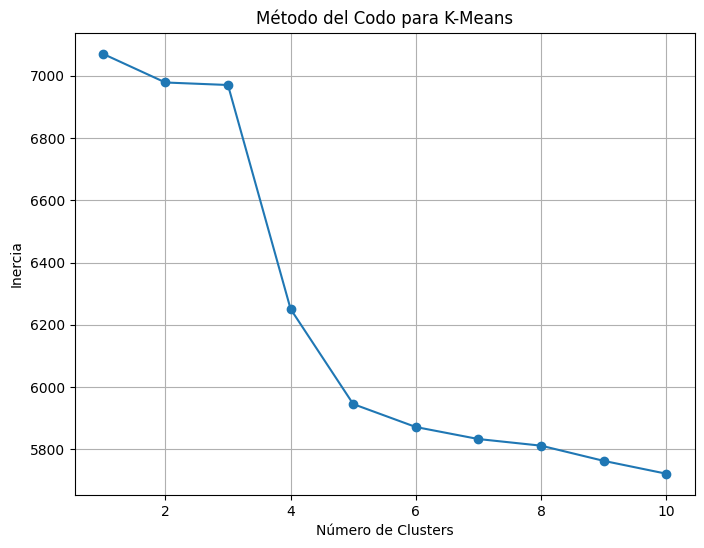

In [96]:
# Vectorización con TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(evaluation_data['Comentarios Procesados NLTK'])

# Método del codo: calcular inercia para diferentes números de clusters
inertias = []
cluster_range = range(1, 11)  # Probar de 1 a 10 clusters
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertias, marker='o')
plt.title('Método del Codo para K-Means')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()

In [97]:
# Clustering con K-Means
kmeans = KMeans(n_clusters=8, random_state=42)  # Ajusta el número de clusters
evaluation_data['Cluster TFIDF NLTK'] = kmeans.fit_predict(X)
evaluation_data.head()

,Id Instructor,Grado Académico,Catálogo,Nº Clase,Nombre Catalogo,Modo de Enseñanza,Centro de Costos,Nota final por curso,Competencia Evaluada,Nota competencia por clase,...,Semestre,Comentarios Procesados Spacy,Comentarios Procesados NLTK,Sentimiento spacy-blob,Sentimiento nltk-blob,Sentimiento spacy-vader,Sentimiento nltk-vader,Sentimiento bert,Sentimiento BERT Clasificado,Cluster TFIDF NLTK
0,1.000096e+09,PREG,PS0301,1615.0,Análisis Descriptivo de Datos,Presencial,Depto. de Psicología,4.39,Comentarios,0.0,...,1,practica tema,practica temas,Neutro,Neutro,Neutro,Neutro,4 stars,Positivo,1
1,1.000096e+09,PREG,PS0301,1383.0,Análisis Descriptivo de Datos,Presencial,Depto. de Psicología,4.39,Comentarios,0.0,...,1,ocurrir,sé ocurre ninguna,Neutro,Neutro,Neutro,Neutro,1 star,Negativo,1
2,1.000001e+09,PREG,PS0302,1384.0,El Objeto de la Psicología,Presencial,Depto. de Psicología,4.57,Comentarios,0.0,...,1,retroalimentar clase,retroalimentar final clase,Neutro,Neutro,Neutro,Neutro,5 stars,Positivo,4
3,1.000005e+09,PREG,PS0302,1384.0,El Objeto de la Psicología,Presencial,Depto. de Psicología,4.57,Comentarios,0.0,...,1,evaluar forma dictar clase hacer él lento abur...,podría evaluar forma dictar clase hacerla tan ...,Neutro,Neutro,Neutro,Neutro,3 stars,Neutro,4
4,1.000266e+09,PREG,PS0303,1385.0,Psicología General I,Presencial,Depto. de Psicología,4.80,Comentarios,0.0,...,1,,,Neutro,Neutro,Neutro,Neutro,1 star,Negativo,1


#### Embeddings

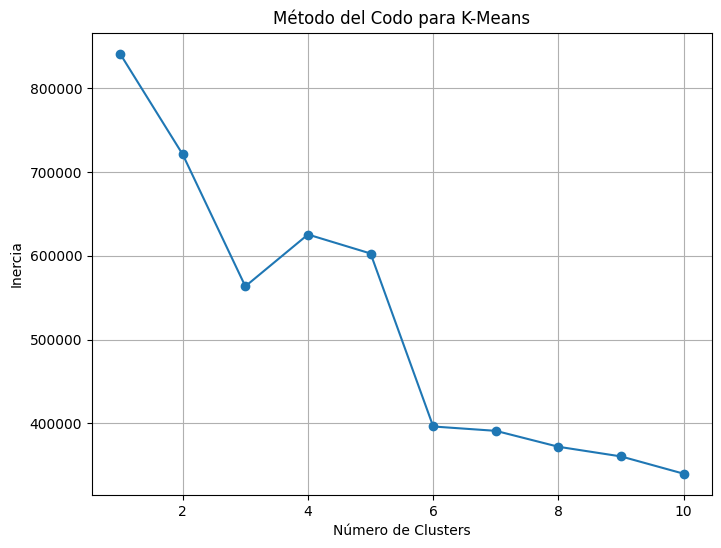

In [98]:
# Función para obtener el vector promedio de un texto
def get_embedding(text):
    doc = nlp(text)
    return doc.vector  # El vector del documento es el promedio de los vectores de las palabras

# Preprocesar los comentarios y obtener los embeddings
evaluation_data['embedding'] = evaluation_data['Comentarios'].apply(lambda x: get_embedding(x))

# Convertir la lista de embeddings en una matriz numpy
X = np.vstack(evaluation_data['embedding'].values)

# Método del codo: calcular inercia para diferentes números de clusters
inertias = []
cluster_range = range(1, 11)  # Probar de 1 a 10 clusters
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertias, marker='o')
plt.title('Método del Codo para K-Means')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()

In [99]:
# Clustering con K-Means
kmeans = KMeans(n_clusters=8, random_state=42)
evaluation_data['Cluster Embedding Spacy'] = kmeans.fit_predict(X)
evaluation_data.head()

,Id Instructor,Grado Académico,Catálogo,Nº Clase,Nombre Catalogo,Modo de Enseñanza,Centro de Costos,Nota final por curso,Competencia Evaluada,Nota competencia por clase,...,Comentarios Procesados NLTK,Sentimiento spacy-blob,Sentimiento nltk-blob,Sentimiento spacy-vader,Sentimiento nltk-vader,Sentimiento bert,Sentimiento BERT Clasificado,Cluster TFIDF NLTK,embedding,Cluster Embedding Spacy
0,1.000096e+09,PREG,PS0301,1615.0,Análisis Descriptivo de Datos,Presencial,Depto. de Psicología,4.39,Comentarios,0.0,...,practica temas,Neutro,Neutro,Neutro,Neutro,4 stars,Positivo,1,"[0.1976761, -1.4007065, -0.27864963, 2.0638082...",2
1,1.000096e+09,PREG,PS0301,1383.0,Análisis Descriptivo de Datos,Presencial,Depto. de Psicología,4.39,Comentarios,0.0,...,sé ocurre ninguna,Neutro,Neutro,Neutro,Neutro,1 star,Negativo,1,"[-0.5550769, 0.3808437, 0.721742, -0.4362604, ...",2
2,1.000001e+09,PREG,PS0302,1384.0,El Objeto de la Psicología,Presencial,Depto. de Psicología,4.57,Comentarios,0.0,...,retroalimentar final clase,Neutro,Neutro,Neutro,Neutro,5 stars,Positivo,4,"[0.86173266, -1.0211694, 0.51857615, -0.388821...",2
3,1.000005e+09,PREG,PS0302,1384.0,El Objeto de la Psicología,Presencial,Depto. de Psicología,4.57,Comentarios,0.0,...,podría evaluar forma dictar clase hacerla tan ...,Neutro,Neutro,Neutro,Neutro,3 stars,Neutro,4,"[-0.29165742, 0.14982958, -0.14382884, 0.25320...",2
4,1.000266e+09,PREG,PS0303,1385.0,Psicología General I,Presencial,Depto. de Psicología,4.80,Comentarios,0.0,...,,Neutro,Neutro,Neutro,Neutro,1 star,Negativo,1,"[0.26304784, -1.0400864, -1.0980119, -2.649713...",6


### DBSCAN Embeddings

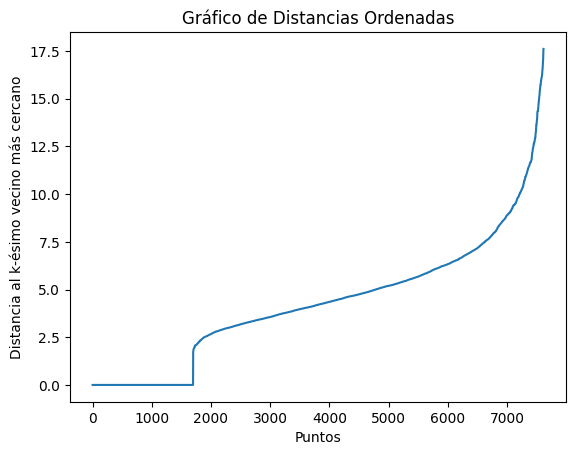

In [100]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Supongamos que X es la matriz de embeddings
neighbors = NearestNeighbors(n_neighbors=5)  # Usamos min_samples como k
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# Ordenar y graficar la distancia al k-ésimo vecino más cercano
distances = np.sort(distances[:, -1], axis=0)
plt.plot(distances)
plt.title('Gráfico de Distancias Ordenadas')
plt.xlabel('Puntos')
plt.ylabel('Distancia al k-ésimo vecino más cercano')
plt.show()


In [101]:
# Definir los parámetros de DBSCAN
eps = 0.35  # Radio de búsqueda
min_samples = 10  # Número mínimo de puntos para formar un cluster

# Aplicar DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
evaluation_data['Cluster DBSCAN'] = dbscan.fit_predict(X)
evaluation_data.head()

,Id Instructor,Grado Académico,Catálogo,Nº Clase,Nombre Catalogo,Modo de Enseñanza,Centro de Costos,Nota final por curso,Competencia Evaluada,Nota competencia por clase,...,Sentimiento spacy-blob,Sentimiento nltk-blob,Sentimiento spacy-vader,Sentimiento nltk-vader,Sentimiento bert,Sentimiento BERT Clasificado,Cluster TFIDF NLTK,embedding,Cluster Embedding Spacy,Cluster DBSCAN
0,1.000096e+09,PREG,PS0301,1615.0,Análisis Descriptivo de Datos,Presencial,Depto. de Psicología,4.39,Comentarios,0.0,...,Neutro,Neutro,Neutro,Neutro,4 stars,Positivo,1,"[0.1976761, -1.4007065, -0.27864963, 2.0638082...",2,0
1,1.000096e+09,PREG,PS0301,1383.0,Análisis Descriptivo de Datos,Presencial,Depto. de Psicología,4.39,Comentarios,0.0,...,Neutro,Neutro,Neutro,Neutro,1 star,Negativo,1,"[-0.5550769, 0.3808437, 0.721742, -0.4362604, ...",2,0
2,1.000001e+09,PREG,PS0302,1384.0,El Objeto de la Psicología,Presencial,Depto. de Psicología,4.57,Comentarios,0.0,...,Neutro,Neutro,Neutro,Neutro,5 stars,Positivo,4,"[0.86173266, -1.0211694, 0.51857615, -0.388821...",2,0
3,1.000005e+09,PREG,PS0302,1384.0,El Objeto de la Psicología,Presencial,Depto. de Psicología,4.57,Comentarios,0.0,...,Neutro,Neutro,Neutro,Neutro,3 stars,Neutro,4,"[-0.29165742, 0.14982958, -0.14382884, 0.25320...",2,0
4,1.000266e+09,PREG,PS0303,1385.0,Psicología General I,Presencial,Depto. de Psicología,4.80,Comentarios,0.0,...,Neutro,Neutro,Neutro,Neutro,1 star,Negativo,1,"[0.26304784, -1.0400864, -1.0980119, -2.649713...",6,0


In [102]:
evaluation_data['Cluster DBSCAN'].value_counts()

Cluster DBSCAN
 0    5679
-1     814
 2     799
 1     263
 3      37
 4      12
 5      12
Name: count, dtype: int64

In [103]:
evaluation_data.columns

Index(['Id Instructor', 'Grado Académico', 'Catálogo', 'Nº Clase',
       'Nombre Catalogo', 'Modo de Enseñanza', 'Centro de Costos',
       'Nota final por curso', 'Competencia Evaluada',
       'Nota competencia por clase', 'Nota final por clase', 'Pregunta',
       'Calificación Pregunta', 'Comentarios', 'Total Evaluaciones generadas',
       'Evaluaciones realizadas', '% de participación',
       'Duracion Curso (dias)', 'Año', 'Semestre',
       'Comentarios Procesados Spacy', 'Comentarios Procesados NLTK',
       'Sentimiento spacy-blob', 'Sentimiento nltk-blob',
       'Sentimiento spacy-vader', 'Sentimiento nltk-vader', 'Sentimiento bert',
       'Sentimiento BERT Clasificado', 'Cluster TFIDF NLTK', 'embedding',
       'Cluster Embedding Spacy', 'Cluster DBSCAN'],
      dtype='object')

In [104]:
evaluation_data = evaluation_data.drop(columns=['embedding'])

In [105]:
evaluation_data.to_csv('Evaluation_Data_Sentiments_Clustering.csv', index=False, sep=';')   

## Data final

In [106]:
evaluation_data.head()

,Id Instructor,Grado Académico,Catálogo,Nº Clase,Nombre Catalogo,Modo de Enseñanza,Centro de Costos,Nota final por curso,Competencia Evaluada,Nota competencia por clase,...,Comentarios Procesados NLTK,Sentimiento spacy-blob,Sentimiento nltk-blob,Sentimiento spacy-vader,Sentimiento nltk-vader,Sentimiento bert,Sentimiento BERT Clasificado,Cluster TFIDF NLTK,Cluster Embedding Spacy,Cluster DBSCAN
0,1.000096e+09,PREG,PS0301,1615.0,Análisis Descriptivo de Datos,Presencial,Depto. de Psicología,4.39,Comentarios,0.0,...,practica temas,Neutro,Neutro,Neutro,Neutro,4 stars,Positivo,1,2,0
1,1.000096e+09,PREG,PS0301,1383.0,Análisis Descriptivo de Datos,Presencial,Depto. de Psicología,4.39,Comentarios,0.0,...,sé ocurre ninguna,Neutro,Neutro,Neutro,Neutro,1 star,Negativo,1,2,0
2,1.000001e+09,PREG,PS0302,1384.0,El Objeto de la Psicología,Presencial,Depto. de Psicología,4.57,Comentarios,0.0,...,retroalimentar final clase,Neutro,Neutro,Neutro,Neutro,5 stars,Positivo,4,2,0
3,1.000005e+09,PREG,PS0302,1384.0,El Objeto de la Psicología,Presencial,Depto. de Psicología,4.57,Comentarios,0.0,...,podría evaluar forma dictar clase hacerla tan ...,Neutro,Neutro,Neutro,Neutro,3 stars,Neutro,4,2,0
4,1.000266e+09,PREG,PS0303,1385.0,Psicología General I,Presencial,Depto. de Psicología,4.80,Comentarios,0.0,...,,Neutro,Neutro,Neutro,Neutro,1 star,Negativo,1,6,0


In [107]:
evaluation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7616 entries, 0 to 7615
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Id Instructor                 7616 non-null   float64
 1   Grado Académico               7616 non-null   object 
 2   Catálogo                      7616 non-null   object 
 3   Nº Clase                      7616 non-null   float64
 4   Nombre Catalogo               7616 non-null   object 
 5   Modo de Enseñanza             7616 non-null   object 
 6   Centro de Costos              7616 non-null   object 
 7   Nota final por curso          7616 non-null   float64
 8   Competencia Evaluada          7616 non-null   object 
 9   Nota competencia por clase    7616 non-null   float64
 10  Nota final por clase          7616 non-null   float64
 11  Pregunta                      7616 non-null   object 
 12  Calificación Pregunta         7616 non-null   float64
 13  Com

In [108]:
evaluation_data['Id Instructor'] = evaluation_data['Id Instructor'].astype('int64')

In [109]:
evaluation_data['Nº Clase'] = evaluation_data['Nº Clase'].astype('int64')

In [110]:
numerical_data = ['Nota final por curso', 'Nota competencia por clase', 'Nota final por clase',
                  'Calificación Pregunta', 'Total Evaluaciones generadas', 'Evaluaciones realizadas',
                  '% de participación', 'Duracion Curso (dias)']
                  

In [111]:
for col in numerical_data:
    evaluation_data[col] = evaluation_data[col].astype(float)  # Asegurarse de que sean flotantes
    evaluation_data[col] = evaluation_data[col].apply(lambda x: f'{x:.2f}'.replace('.', ','))

In [112]:
evaluation_data.head()

,Id Instructor,Grado Académico,Catálogo,Nº Clase,Nombre Catalogo,Modo de Enseñanza,Centro de Costos,Nota final por curso,Competencia Evaluada,Nota competencia por clase,...,Comentarios Procesados NLTK,Sentimiento spacy-blob,Sentimiento nltk-blob,Sentimiento spacy-vader,Sentimiento nltk-vader,Sentimiento bert,Sentimiento BERT Clasificado,Cluster TFIDF NLTK,Cluster Embedding Spacy,Cluster DBSCAN
0,1000096395,PREG,PS0301,1615,Análisis Descriptivo de Datos,Presencial,Depto. de Psicología,"4,39",Comentarios,"0,00",...,practica temas,Neutro,Neutro,Neutro,Neutro,4 stars,Positivo,1,2,0
1,1000096395,PREG,PS0301,1383,Análisis Descriptivo de Datos,Presencial,Depto. de Psicología,"4,39",Comentarios,"0,00",...,sé ocurre ninguna,Neutro,Neutro,Neutro,Neutro,1 star,Negativo,1,2,0
2,1000001181,PREG,PS0302,1384,El Objeto de la Psicología,Presencial,Depto. de Psicología,"4,57",Comentarios,"0,00",...,retroalimentar final clase,Neutro,Neutro,Neutro,Neutro,5 stars,Positivo,4,2,0
3,1000004552,PREG,PS0302,1384,El Objeto de la Psicología,Presencial,Depto. de Psicología,"4,57",Comentarios,"0,00",...,podría evaluar forma dictar clase hacerla tan ...,Neutro,Neutro,Neutro,Neutro,3 stars,Neutro,4,2,0
4,1000265727,PREG,PS0303,1385,Psicología General I,Presencial,Depto. de Psicología,"4,80",Comentarios,"0,00",...,,Neutro,Neutro,Neutro,Neutro,1 star,Negativo,1,6,0


In [113]:
evaluation_data.to_csv('Evaluation_Data_Sentiments_Clustering1.csv', index=False, sep=';')

In [114]:
data = pd.read_csv('Evaluation_Data_Sentiments_Clustering.csv', sep=';')

In [115]:
data.describe()

,Id Instructor,Nº Clase,Nota final por curso,Nota competencia por clase,Nota final por clase,Calificación Pregunta,Total Evaluaciones generadas,Evaluaciones realizadas,% de participación,Duracion Curso (dias),Año,Semestre,Cluster TFIDF NLTK,Cluster Embedding Spacy,Cluster DBSCAN
count,7.616000e+03,7616.000000,7616.000000,7616.0,7616.000000,7616.0,7616.000000,7616.000000,7616.000000,7616.000000,7616.0,7616.0,7616.000000,7616.000000,7616.000000
mean,1.449335e+09,5863.415441,4.705481,0.0,4.704011,0.0,21.866892,20.650771,95.465576,111.671412,2024.0,1.0,2.596376,2.363971,0.166229
std,1.960448e+09,13646.730219,0.306504,0.0,0.321019,0.0,9.017097,8.575477,9.630163,20.731106,0.0,0.0,2.223945,1.505825,0.801144
min,1.000000e+09,1258.000000,2.960000,0.0,0.000000,0.0,1.000000,1.000000,3.230000,12.000000,2024.0,1.0,0.000000,0.000000,-1.000000
25%,1.000060e+09,1420.750000,4.640000,0.0,4.630000,0.0,16.000000,15.000000,95.000000,111.698730,2024.0,1.0,1.000000,2.000000,0.000000
50%,1.000089e+09,1516.000000,4.750000,0.0,4.760000,0.0,21.857289,20.642245,96.880000,119.000000,2024.0,1.0,1.000000,2.000000,0.000000
75%,1.000125e+09,5187.000000,4.910000,0.0,4.910000,0.0,29.000000,27.000000,100.000000,119.000000,2024.0,1.0,5.000000,3.000000,0.000000
max,1.000363e+10,64620.000000,5.000000,0.0,5.000000,0.0,40.000000,35.000000,100.000000,181.000000,2024.0,1.0,7.000000,7.000000,5.000000
